In [1]:
import os
import re
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, GlobalMaxPooling1D
from keras.layers import Conv1D,Conv2D, MaxPooling1D, Embedding
from keras.models import Model
from sklearn.metrics import roc_auc_score
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import wordnet
import string
from sklearn.model_selection import train_test_split


In [2]:
MAX_SEQUENCE_LENGTH= 100
MAX_VOCAB_SIZE =20000
EMBEDDING_DIM=100
VALIDATION_SPLIT =0.2
BATCH_SIZE =128
EPOCHS =10

In [3]:
word2vec = {}
with open ("/Users/jghosh2/Documents/my-notebook/L1 triage POC/code/glove.6B.100d.txt")as f:
    for line in f:
        values=line.split()
        word=values[0]
        vec = np.asarray(values[1:], dtype="float32")
        word2vec[word] =vec  

In [4]:
len(word2vec)

400000

In [5]:
def preprocess_text(message):

    #stopwords
    new_stopwords=['the','on','hi','hello','team','ext','jira','thanks','hey','regards',
                   'please','jira','uber','com','for','to','in','and','not','ext']
    stpwrd = nltk.corpus.stopwords.words('english')
    stpwrd.extend(new_stopwords)
    # 1. Init Lemmatizer
    lemmatizer = WordNetLemmatizer()
    #removing the numerical values and working only with text values
    message = re.sub('[^a-zA-Z]', " ", message )
    #lowering and removing punctuation
    message = re.sub(r'[^\w\s]','', message.lower())
    #removing the stopwords
    message = ' '.join([word for word in message.split() if word not in stpwrd and len(word)>2])
    #lemmatizing the text
    message =  " ".join([lemmatizer.lemmatize(w) for w in nltk.word_tokenize(message) if w not in string.punctuation])
    #message = [lemmatizer.lemmatize(w) for w in nltk.word_tokenize(message) if w not in string.punctuation]
    #tagged_sentence = nltk.tag.pos_tag(message.split())
    #edited_sentence = [word for word,tag in tagged_sentence if tag != 'NNP' or tag != 'NNPS']
    #message =  " ".join(edited_sentence)
    return message

In [6]:
#read input from historical data into dataframe
data_df = pd.read_excel('/Users/jghosh2/Documents/my-notebook/L1 triage POC/data/Updated-JIRA_DUMP_Mar_2020_March_2022_Sourabh.xlsx',usecols=['Summary','Description','Component'])
#choose sample data from entire data
data_df = data_df.sample(frac=1, random_state=42)
data_df['Summary']=data_df['Summary'].astype(str)
data_df['Description']=data_df['Description'].astype(str)
data_df.dropna()
data_df['combined_text'] = data_df[['Summary','Description']].apply(lambda x: ' '.join(x[x.notnull()]), axis = 1)
data_df['processed_text'] = data_df['combined_text'].map(lambda s:preprocess_text(s)) 
print(data_df.shape)
data_df=data_df.drop_duplicates(subset=['processed_text','Component'],keep='first')
print(data_df.shape)
data_df = data_df.reset_index(drop=True)
X = data_df[['Summary','Description','processed_text']]
y = data_df['Component']


(44513, 5)
(39630, 5)


In [7]:
sentences_train=X['processed_text'].values
#sentences_test=X['processed_text'].values

In [8]:
#targets = data_df['Component'].values
from sklearn.preprocessing import LabelBinarizer
y = LabelBinarizer().fit_transform(data_df.Component)
y_train=y
#y_test=y[30000:]

In [9]:
targets_train=y_train
#targets_test=y_test

In [10]:
#targets_train.shape

In [11]:
from keras.preprocessing.text import Tokenizer

In [12]:
tokenizer= Tokenizer(num_words=MAX_VOCAB_SIZE)


In [13]:
tokenizer.fit_on_texts(sentences_train)


In [14]:
sequences_train = tokenizer.texts_to_sequences(sentences_train)
#sequences_test = tokenizer.texts_to_sequences(sentences_test)


In [15]:
tokenizer.document_count

39630

In [16]:
tokenizer.word_counts

OrderedDict([('atg', 966),
             ('hypertechnologie', 5),
             ('ciara', 60),
             ('inc', 4107),
             ('provide', 4903),
             ('pdf', 3659),
             ('copy', 1832),
             ('issued', 341),
             ('supplier', 13202),
             ('aaron', 1069),
             ('richard', 84),
             ('chan', 272),
             ('rchan', 3),
             ('aurora', 112),
             ('tech', 484),
             ('date', 13270),
             ('tuesday', 420),
             ('june', 758),
             ('bertram', 585),
             ('abertram', 793),
             ('subject', 5563),
             ('sent', 3761),
             ('trying', 2513),
             ('figure', 112),
             ('still', 2377),
             ('valid', 713),
             ('open', 4847),
             ('probably', 65),
             ('easiest', 17),
             ('nick', 206),
             ('see', 5833),
             ('actual', 342),
             ('tue', 3366),
             ('j

In [17]:
tokenizer.word_index
#sequences_train

{'mailto': 1,
 'http': 2,
 'invoice': 3,
 'png': 4,
 'account': 5,
 'quote': 6,
 'request': 7,
 'error': 8,
 'thumbnail': 9,
 'email': 10,
 'missing': 11,
 'image': 12,
 'scheduler': 13,
 'oracle': 14,
 'access': 15,
 'name': 16,
 'coupa': 17,
 'otm': 18,
 'reference': 19,
 'payment': 20,
 'report': 21,
 'date': 22,
 'supplier': 23,
 'warning': 24,
 'wrote': 25,
 'create': 26,
 'approval': 27,
 'mar': 28,
 'user': 29,
 'customer': 30,
 'entity': 31,
 'new': 32,
 'uberinternal': 33,
 'support': 34,
 'need': 35,
 'issue': 36,
 'file': 37,
 'message': 38,
 'sys': 39,
 'could': 40,
 'orig': 41,
 'thank': 42,
 'address': 43,
 'logo': 44,
 'fintech': 45,
 'help': 46,
 'feb': 47,
 'jan': 48,
 'change': 49,
 'dec': 50,
 'may': 51,
 'www': 52,
 'apr': 53,
 'number': 54,
 'program': 55,
 'check': 56,
 'detail': 57,
 'global': 58,
 'receipt': 59,
 'mail': 60,
 'tax': 61,
 'manager': 62,
 'process': 63,
 'group': 64,
 'code': 65,
 'google': 66,
 'company': 67,
 'cost': 68,
 'know': 69,
 'approver'

In [18]:
print("max sequence length:", max(len(s) for s in sequences_train))
print("min sequence length:", min(len(s) for s in sequences_train))
s = sorted(len(s) for s in sequences_train)
print("median sequence length:", s[len(s) // 2])

print("max word index:", max(max(seq) for seq in sequences_train if len(seq) > 0))


# get word -> integer mapping
word2idx = tokenizer.word_index
print('Found %s unique tokens.' % len(word2idx))

max sequence length: 2935
min sequence length: 0
median sequence length: 36
max word index: 19999
Found 80110 unique tokens.


In [19]:
# pad sequences so that we get a N x T matrix
data = pad_sequences(sequences_train, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', data.shape)

Shape of data tensor: (39630, 100)


In [20]:
data = pad_sequences(sequences_train, maxlen=MAX_SEQUENCE_LENGTH)
#sequences_train[1]

In [21]:
print('Shape of data tensor:', data.shape)
data.shape

Shape of data tensor: (39630, 100)


(39630, 100)

In [22]:
print(MAX_VOCAB_SIZE,len(word2idx) + 1,min(MAX_VOCAB_SIZE, len(word2idx) + 1))
num_words = min(MAX_VOCAB_SIZE, len(word2idx) + 1)
print(num_words)
EMBEDDING_DIM
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
print(embedding_matrix.shape )#V X D (Dimensions)


20000 80111 20000
20000
(20000, 100)


In [23]:
for word, i in word2idx.items():
    word2vec.get(word)

In [24]:
len(word2vec)

400000

In [25]:
for word, i in word2idx.items():
    print(word,i)

mailto 1
http 2
invoice 3
png 4
account 5
quote 6
request 7
error 8
thumbnail 9
email 10
missing 11
image 12
scheduler 13
oracle 14
access 15
name 16
coupa 17
otm 18
reference 19
payment 20
report 21
date 22
supplier 23
warning 24
wrote 25
create 26
approval 27
mar 28
user 29
customer 30
entity 31
new 32
uberinternal 33
support 34
need 35
issue 36
file 37
message 38
sys 39
could 40
orig 41
thank 42
address 43
logo 44
fintech 45
help 46
feb 47
jan 48
change 49
dec 50
may 51
www 52
apr 53
number 54
program 55
check 56
detail 57
global 58
receipt 59
mail 60
tax 61
manager 62
process 63
group 64
code 65
google 66
company 67
cost 68
know 69
approver 70
finapps 71
following 72
let 73
data 74
update 75
status 76
grp 77
logistics 78
portal 79
validation 80
see 81
end 82
operation 83
jul 84
aug 85
service 86
hfm 87
subject 88
cust 89
attached 90
bank 91
batchb 92
emea 93
period 94
business 95
order 96
usd 97
stage 98
null 99
provide 100
open 101
pay 102
line 103
oct 104
static 105
prod 106
tran

accrued 907
cholev 908
michael 909
given 910
release 911
deepak 912
virus 913
outstanding 914
every 915
old 916
discussion 917
onelogin 918
anup 919
certa 920
transit 921
scheduled 922
francisco 923
january 924
invoicing 925
agent 926
reserved 927
air 928
push 929
usa 930
domainname 931
pragna 932
krishna 933
olgal 934
citiconnect 935
dba 936
perform 937
home 938
nirmaljain 939
whether 940
msg 941
rpt 942
automatically 943
fpa 944
nancy 945
category 946
august 947
mike 948
furl 949
recently 950
calendar 951
appreciate 952
move 953
carmen 954
problem 955
sea 956
monitor 957
even 958
dupont 959
bizops 960
zoom 961
tracking 962
lookup 963
patel 964
resubmit 965
ltda 966
sid 967
synced 968
protection 969
vijay 970
requestor 971
runtime 972
price 973
sreedhar 974
gmbh 975
future 976
msgid 977
brazil 978
stop 979
give 980
facing 981
contains 982
street 983
clear 984
delay 985
yoke 986
limit 987
happy 988
tag 989
hinter 990
sso 991
enable 992
phase 993
pvt 994
forecast 995
enabled 996
posting

withholding 1907
session 1908
santosh 1909
afternoon 1910
venkata 1911
trainer 1912
ana 1913
sarique 1914
suppliermanagementsupport 1915
buyeropssupport 1916
reviewed 1917
pearlman 1918
assistant 1919
comm 1920
prakash 1921
happened 1922
suggest 1923
lilesh 1924
manage 1925
said 1926
respond 1927
identified 1928
preparer 1929
jamie 1930
peter 1931
thought 1932
ilonaz 1933
toliveira 1934
xmlbasewrapper 1935
specified 1936
ubr 1937
dbadm 1938
rom 1939
york 1940
reddy 1941
rama 1942
clarification 1943
placeholder 1944
adi 1945
dollar 1946
satyanarayana 1947
roger 1948
kim 1949
aesthe 1950
val 1951
seem 1952
leasing 1953
iiqhi 1954
ending 1955
flores 1956
laura 1957
krw 1958
fdefi 1959
upon 1960
administrator 1961
treas 1962
joined 1963
scott 1964
amt 1965
hyd 1966
insight 1967
kline 1968
ben 1969
interest 1970
carolyn 1971
pgp 1972
jfigue 1973
modifying 1974
csa 1975
cbc 1976
feedback 1977
certificate 1978
begin 1979
psp 1980
hard 1981
went 1982
bhuvika 1983
neha 1984
smartview 1985
chewy

bic 2906
bucket 2907
noreplyptoisih 2908
wfmail 2909
wan 2910
diana 2911
jussara 2912
prepare 2913
cdttrftxinf 2914
yeo 2915
object 2916
deduction 2917
temporary 2918
nyadav 2919
rea 2920
wilson 2921
evening 2922
akkaraju 2923
bcoupa 2924
workspace 2925
philippine 2926
akula 2927
transition 2928
unique 2929
hub 2930
vi 2931
dramdas 2932
context 2933
felipe 2934
union 2935
johnny 2936
eduardo 2937
homer 2938
cfdcef 2939
bonino 2940
baseinterface 2941
memoryeventqueuerunnable 2942
psteam 2943
cqotmc 2944
usdc 2945
nelluru 2946
baeur 2947
bapprovals 2948
anomaly 2949
historical 2950
opex 2951
anvesh 2952
wrd 2953
chensenior 2954
drop 2955
sydney 2956
morale 2957
reaanne 2958
retrieve 2959
consulting 2960
pkr 2961
faizan 2962
ryder 2963
faehndrich 2964
ufo 2965
zvinska 2966
execution 2967
strategy 2968
btt 2969
beeraka 2970
pharmavite 2971
greater 2972
tran 2973
srinivas 2974
chakkirala 2975
suggestion 2976
egz 2977
atom 2978
holiday 2979
nicholas 2980
canceled 2981
written 2982
vargas 298

israel 3906
bean 3907
ffea 3908
chad 3909
merged 3910
denied 3911
hsiaoen 3912
preparation 3913
reinitiate 3914
osman 3915
formstack 3916
giphy 3917
augusto 3918
taxi 3919
affected 3920
restore 3921
movement 3922
counsel 3923
bnf 3924
horizon 3925
bailey 3926
downloading 3927
holive 3928
nathalie 3929
incentive 3930
sedapa 3931
kamalakar 3932
huynh 3933
dinesh 3934
schand 3935
jha 3936
integrator 3937
gru 3938
individually 3939
lkado 3940
royalty 3941
lsingo 3942
expecting 3943
super 3944
pudumu 3945
tied 3946
oleh 3947
weterings 3948
identity 3949
gregg 3950
nathan 3951
da 3952
trial 3953
reqs 3954
venturino 3955
reclasses 3956
ross 3957
excluded 3958
lithuania 3959
contra 3960
shubham 3961
rosa 3962
viswa 3963
sri 3964
scoville 3965
joan 3966
brish 3967
will 3968
nsravankumar 3969
writeoff 3970
flexi 3971
away 3972
siddiqui 3973
interco 3974
platinum 3975
fsli 3976
christiaan 3977
cooperation 3978
debt 3979
frequency 3980
spyara 3981
tor 3982
stakeholder 3983
ozgmp 3984
auzesmlrr 398

maureira 4905
sulista 4906
fireeye 4907
hcde 4908
unter 4909
copyright 4910
linux 4911
fid 4912
marshall 4913
handled 4914
inconvenience 4915
firefox 4916
config 4917
teng 4918
estimate 4919
vijaykumar 4920
talk 4921
rroger 4922
huge 4923
crisardy 4924
maximum 4925
leadership 4926
break 4927
dsignature 4928
controversy 4929
swag 4930
guideline 4931
afb 4932
dbc 4933
gobalakrishnan 4934
uwi 4935
jportugal 4936
tinali 4937
meenakshi 4938
hellas 4939
sufficient 4940
replacing 4941
pc 4942
friendly 4943
uom 4944
mumbai 4945
corrective 4946
environmental 4947
bat 4948
yoobee 4949
yun 4950
initiation 4951
rosemary 4952
bhan 4953
retirement 4954
shubha 4955
acef 4956
avarela 4957
chandubejawada 4958
essential 4959
suparno 4960
sanket 4961
jmarfe 4962
rteran 4963
chuck 4964
armor 4965
greece 4966
wen 4967
jspa 4968
kitchen 4969
readiness 4970
paste 4971
sterling 4972
duplicated 4973
constraint 4974
kellen 4975
recording 4976
sap 4977
uberbvstock 4978
utistock 4979
shom 4980
jdogip 4981
deerfie

bsr 5905
mack 5906
pfrankel 5907
backfill 5908
raza 5909
unsuccessful 5910
dm 5911
hsbcnet 5912
guaranteed 5913
escribi 5914
partially 5915
vtc 5916
lele 5917
ako 5918
joyceh 5919
rrincon 5920
pavankumar 5921
pbuck 5922
unitas 5923
reyna 5924
ecdsa 5925
ecdh 5926
joshyates 5927
nip 5928
yambao 5929
suarez 5930
ruth 5931
calliana 5932
peterson 5933
organisation 5934
grooveapp 5935
heinz 5936
ngeorg 5937
pocs 5938
nagabelly 5939
bumping 5940
spilla 5941
entering 5942
jeevan 5943
verizon 5944
expedited 5945
rocha 5946
light 5947
flight 5948
minimum 5949
harrag 5950
valdez 5951
often 5952
othr 5953
jamboju 5954
keir 5955
kunjan 5956
yagati 5957
spusa 5958
southern 5959
rca 5960
flagging 5961
ketan 5962
milestone 5963
kelsey 5964
sjanam 5965
rohan 5966
amogreentech 5967
gave 5968
sold 5969
pta 5970
american 5971
erp 5972
ivy 5973
glbalances 5974
sdasoh 5975
doha 5976
manner 5977
pparee 5978
cjp 5979
sip 5980
cim 5981
established 5982
commerce 5983
toll 5984
pov 5985
hawb 5986
matric 5987
ec

gracias 6884
jangidi 6885
integrating 6886
hom 6887
madhavakiran 6888
devaj 6889
rectify 6890
discovered 6891
prashant 6892
ding 6893
catch 6894
owns 6895
servi 6896
vance 6897
million 6898
tprm 6899
playbook 6900
slip 6901
cbd 6902
decided 6903
updation 6904
minimal 6905
rejecting 6906
cairo 6907
cokeef 6908
designee 6909
proactive 6910
tims 6911
finreporting 6912
cheryl 6913
amey 6914
subinventory 6915
basheeruddin 6916
canceling 6917
graham 6918
joinee 6919
incase 6920
iev 6921
underlying 6922
rationale 6923
bucek 6924
roshan 6925
epmuat 6926
vsheri 6927
barnett 6928
edisetups 6929
readhimer 6930
vaddivalli 6931
littler 6932
mendelson 6933
shin 6934
pub 6935
luke 6936
consignee 6937
studio 6938
apart 6939
hectorr 6940
hilmar 6941
kcp 6942
odd 6943
svanr 6944
implementing 6945
yahoo 6946
kmak 6947
alvarado 6948
comdata 6949
pago 6950
gomes 6951
beirut 6952
jurisdiction 6953
excl 6954
moreno 6955
derived 6956
abates 6957
credding 6958
natasha 6959
jsteward 6960
golestaneh 6961
excess 

inactivate 7805
boulevard 7806
borschke 7807
grur 7808
osj 7809
tewari 7810
todos 7811
rangel 7812
prompted 7813
panuganti 7814
ltbk 7815
hceakcdmxijy 7816
vku 7817
upnap 7818
vbx 7819
punwal 7820
emeauber 7821
nitin 7822
vern 7823
kuykendall 7824
shop 7825
aditya 7826
efficient 7827
eosits 7828
rex 7829
dsa 7830
steward 7831
hall 7832
originator 7833
mohamed 7834
sheehan 7835
kelley 7836
aqton 7837
collecting 7838
specialchargecode 7839
ppwwcsroiaqhf 7840
fmty 7841
ffkxt 7842
jobby 7843
echevarria 7844
roland 7845
sponsorship 7846
casel 7847
concept 7848
junia 7849
jsena 7850
jayashree 7851
nica 7852
navarro 7853
ksa 7854
reward 7855
drobertson 7856
sdmonteiro 7857
bmamat 7858
detach 7859
proj 7860
como 7861
insertupdate 7862
mti 7863
fa 7864
ppa 7865
sars 7866
bordoy 7867
plele 7868
hnl 7869
vanderstoep 7870
atul 7871
inactivated 7872
ing 7873
roney 7874
retainam 7875
ayala 7876
jcordo 7877
lan 7878
manus 7879
eugenie 7880
cary 7881
paymentsubmitted 7882
tcm 7883
dean 7884
otero 7885

rebate 8655
namagiri 8656
achievement 8657
johannes 8658
orca 8659
rajan 8660
alone 8661
bchdbachf 8662
mrc 8663
hdfc 8664
elhanafi 8665
chime 8666
yana 8667
sydr 8668
headquarters 8669
treatment 8670
delegatingconstructoraccessorimpl 8671
herein 8672
haryana 8673
edition 8674
kbean 8675
dkk 8676
mcnell 8677
accts 8678
lsa 8679
tomas 8680
il 8681
sajiv 8682
kaatee 8683
banerjee 8684
samuel 8685
cio 8686
bharat 8687
bgc 8688
steyer 8689
fowler 8690
bthorsen 8691
canarymarketing 8692
expen 8693
myrna 8694
zafar 8695
coo 8696
vuxius 8697
ukbqfa 8698
tnzy 8699
ioxyt 8700
zozhalhaifkndt 8701
zho 8702
numxuoi 8703
vjuubhrc 8704
pbepcchnyqntlmfltihbx 8705
atzz 8706
qkrblxfvmr 8707
dservice 8708
shau 8709
lionellhuang 8710
curiosity 8711
tgxx 8712
isupplier 8713
ite 8714
authenticate 8715
mudit 8716
rsvp 8717
abhinay 8718
cobb 8719
identityiq 8720
usha 8721
rapyd 8722
slavin 8723
lamberti 8724
chauncey 8725
aside 8726
sjambo 8727
thirumalesh 8728
molinari 8729
mzc 8730
rincon 8731
internaciona

roberta 9653
hameed 9654
exide 9655
kyribasupport 9656
undo 9657
ponsgpmsp 9658
vijkrishb 9659
pbn 9660
delia 9661
liasion 9662
dlq 9663
donovan 9664
soci 9665
smg 9666
fort 9667
elangovan 9668
wfapproval 9669
dinline 9670
dthrough 9671
dcoronavirus 9672
dimpact 9673
stoyan 9674
bce 9675
dic 9676
winston 9677
zhan 9678
airtel 9679
sert 9680
crowe 9681
brussel 9682
kloster 9683
juha 9684
carrie 9685
sitcdb 9686
bedi 9687
mdangr 9688
curtis 9689
idc 9690
tyson 9691
vkawal 9692
lizo 9693
clientservice 9694
degla 9695
tec 9696
ocretriever 9697
uuuu 9698
efb 9699
northern 9700
receiverid 9701
orderendt 9702
tma 9703
iza 9704
delhi 9705
rolive 9706
mostly 9707
gpfwginmzz 9708
dikjks 9709
muajsrcll 9710
charging 9711
slight 9712
font 9713
chavez 9714
consuming 9715
kotha 9716
jkotha 9717
novamex 9718
resubmissions 9719
becomes 9720
inspection 9721
polish 9722
reinstated 9723
servletrequestimpl 9724
componentinvocationcontextmanager 9725
executethread 9726
anb 9727
hotker 9728
crm 9729
rref 97

luthmmrrw 10652
wha 10653
hjdrljppb 10654
keobv 10655
uuudwmovayq 10656
mummkxsttst 10657
art 10658
tentative 10659
gschip 10660
colour 10661
micah 10662
zylo 10663
satisfaction 10664
resides 10665
thrinata 10666
sheefa 10667
mortimer 10668
jia 10669
valley 10670
trupti 10671
fargo 10672
bbrilh 10673
instructing 10674
funded 10675
directive 10676
personalization 10677
vampu 10678
lightning 10679
prep 10680
bhatia 10681
preview 10682
incorporation 10683
offering 10684
sath 10685
mcampo 10686
pipe 10687
kharrat 10688
wework 10689
pothana 10690
kozar 10691
son 10692
rubio 10693
cerney 10694
bpa 10695
josephine 10696
chrobinson 10697
bdkcctdkk 10698
vidhya 10699
macaraig 10700
volvo 10701
technically 10702
aby 10703
johnston 10704
detray 10705
emergency 10706
sinead 10707
devane 10708
arjuns 10709
plant 10710
uncosted 10711
celiney 10712
suburb 10713
ageing 10714
concatenate 10715
particularly 10716
schwake 10717
developing 10718
mty 10719
aruane 10720
icx 10721
bsedctsek 10722
kchara 1072

bdkdctdkk 11652
lga 11653
hogan 11654
lovell 11655
meghna 11656
alo 11657
hloure 11658
ysarah 11659
enquiry 11660
ubrqs 11661
arin 11662
regus 11663
ssyd 11664
esp 11665
stephan 11666
anders 11667
analyse 11668
uaccrual 11669
rolling 11670
dharmendra 11671
bolghand 11672
madhabathula 11673
syntax 11674
interval 11675
libbey 11676
nrudolph 11677
tbi 11678
szx 11679
rbando 11680
trivedi 11681
amoham 11682
mtirum 11683
chk 11684
zcolli 11685
schouten 11686
olivier 11687
represents 11688
orauat 11689
fhow 11690
fprocure 11691
marque 11692
southernstates 11693
bright 11694
mix 11695
branded 11696
jmccall 11697
polymer 11698
bauddhaloka 11699
keywords 11700
villarreal 11701
vivin 11702
ribeiro 11703
gbr 11704
sher 11705
eyond 11706
xcellence 11707
eporting 11708
umvkmg 11709
fgyrna 11710
cvalde 11711
unconfirmed 11712
mcj 11713
bos 11714
batchexported 11715
trintec 11716
rfn 11717
sanitation 11718
inputted 11719
kremer 11720
seamless 11721
nichols 11722
wealth 11723
kat 11724
grey 11725
breq

xmkancfagynghppln 12651
jwzgmc 12652
aie 12653
hjdf 12654
bgolujrpyhawzaemsn 12655
ldi 12656
rdwrwgaymjfptl 12657
aeebnup 12658
cvgllkbmmgmcztthyism 12659
oyam 12660
ophxozrspvwou 12661
qqajdnfh 12662
knrmbwh 12663
sonoco 12664
nobody 12665
edgardo 12666
varindani 12667
twest 12668
dwrq 12669
bugdctugx 12670
mall 12671
jjm 12672
servico 12673
ajuda 12674
cnb 12675
jrg 12676
acb 12677
etika 12678
puneetg 12679
worklist 12680
peixoto 12681
ficaja 12682
chew 12683
passphrase 12684
rub 12685
sbaji 12686
malhan 12687
ledonne 12688
thisor 12689
jvco 12690
concurrently 12691
peng 12692
sev 12693
csm 12694
mwm 12695
jambo 12696
newmancorporate 12697
marqeta 12698
limo 12699
justine 12700
glove 12701
palmolive 12702
behaviour 12703
fuvb 12704
znq 12705
flhwvf 12706
czv 12707
kgpstmvexwy 12708
dvc 12709
crxbohn 12710
wmqyzevbjhyz 12711
zrbrl 12712
gjvhe 12713
stxe 12714
jltaxkixvrgfmg 12715
rqdnmihabzqwpfcnnod 12716
osexb 12717
messaging 12718
turhan 12719
dawn 12720
shahid 12721
wonderful 12722

rick 13651
tat 13652
alot 13653
leonardo 13654
reconciles 13655
gattu 13656
batchscripts 13657
qwikcilver 13658
etsu 13659
zjacobs 13660
greulich 13661
uihbv 13662
qpr 13663
recap 13664
dania 13665
ibrahimi 13666
compute 13667
eef 13668
mari 13669
cachart 13670
graju 13671
oralce 13672
effectively 13673
kan 13674
zde 13675
surprise 13676
specialisttravel 13677
ccc 13678
drilldown 13679
compra 13680
anexo 13681
mmt 13682
dhingra 13683
dobrusin 13684
divestiture 13685
fcf 13686
masako 13687
tiny 13688
aubree 13689
brilhante 13690
transmitting 13691
oinstall 13692
kabushikigaisha 13693
obsolete 13694
lint 13695
odx 13696
cpt 13697
xcc 13698
dlr 13699
rah 13700
winowich 13701
crj 13702
puertorico 13703
yubico 13704
wfw 13705
assembly 13706
szyvxafsrdoa 13707
ckiyv 13708
ncl 13709
xgb 13710
wvmi 13711
deprecate 13712
eyring 13713
fext 13714
akar 13715
wear 13716
pmouni 13717
ctxof 13718
bronx 13719
serengeti 13720
fiesta 13721
qid 13722
doubled 13723
tibe 13724
estou 13725
sobre 13726
chien

merrycom 14525
nandana 14526
aligning 14527
kickoff 14528
incur 14529
ddbe 14530
shifted 14531
segregate 14532
zhong 14533
vandertol 14534
unsatisfied 14535
thanu 14536
eeid 14537
lobby 14538
financing 14539
vvardh 14540
resubs 14541
jeaneth 14542
surrey 14543
kemal 14544
ataturk 14545
banani 14546
welch 14547
conn 14548
fabian 14549
lockner 14550
bnp 14551
stream 14552
rhny 14553
kronfol 14554
asulebanon 14555
rene 14556
vasanta 14557
belley 14558
wessell 14559
humanos 14560
mkheerbat 14561
caldeira 14562
wfm 14563
defense 14564
yamara 14565
jairaj 14566
chiaritobilling 14567
acccount 14568
securitypatch 14569
indefinitely 14570
alberti 14571
lavin 14572
crossed 14573
fff 14574
indiaregion 14575
bissell 14576
historic 14577
noreplyptoisie 14578
shambhavi 14579
ctaed 14580
noreplyptoisii 14581
traveling 14582
affinitas 14583
tutorial 14584
unbill 14585
performs 14586
connell 14587
pattiradjawane 14588
collectively 14589
instantpay 14590
jamal 14591
chmod 14592
sakaray 14593
dbtwd 14594

bgtdctgtq 15650
uam 15651
giorgia 15652
severely 15653
rir 15654
defining 15655
ghiaxaowdudu 15656
xhji 15657
altt 15658
fdw 15659
pviqyr 15660
ewj 15661
btwhxc 15662
bpqcfcegpa 15663
bhjx 15664
iipkpphl 15665
gikshel 15666
irmbo 15667
lsqvox 15668
repurpose 15669
villanueva 15670
rise 15671
huf 15672
canon 15673
keyboard 15674
eat 15675
collard 15676
xfb 15677
bnoreply 15678
daiohs 15679
konduru 15680
tausif 15681
trailer 15682
oude 15683
exiting 15684
dormant 15685
ban 15686
unaware 15687
lmoreno 15688
bno 15689
nagasai 15690
kalyan 15691
yamauchi 15692
statem 15693
standpoint 15694
sarfraz 15695
cashpartnership 15696
paeur 15697
personalized 15698
remotely 15699
abroad 15700
teamcould 15701
guangdong 15702
gig 15703
ceac 15704
kalwoju 15705
carbon 15706
recursos 15707
cyber 15708
bputnam 15709
warner 15710
niharika 15711
agueda 15712
brussels 15713
kanban 15714
reclassified 15715
proveedores 15716
accountantinternational 15717
rai 15718
amort 15719
mfp 15720
recog 15721
senderaddres

tpmv 16649
rknhoulogedmfbnafki 16650
genesys 16651
knock 16652
maxime 16653
aya 16654
ac 16655
rsr 16656
salma 16657
dham 16658
avq 16659
gkon 16660
svs 16661
fzifvii 16662
dlra 16663
zwr 16664
vybm 16665
crw 16666
iqgnwolk 16667
tcenh 16668
dmqtstuocccffe 16669
plstnwcjelhydpcdsnlaganphqgkd 16670
ofnofyshk 16671
udpate 16672
fsg 16673
pranesh 16674
lending 16675
jdbcutil 16676
jts 16677
rmidatasource 16678
connectionprovider 16679
bhealthstatus 16680
reperformance 16681
xvm 16682
mieb 16683
kel 16684
fred 16685
deputy 16686
secretary 16687
njov 16688
vypld 16689
qaqprxmvpn 16690
fxiuvzuvfktcepcac 16691
wpgcjpz 16692
uberquotechile 16693
yuna 16694
inability 16695
limpeza 16696
ufszk 16697
tmvqobh 16698
rupyhrdhfhizuqhhlsvfdelssdhxyknm 16699
wnbpva 16700
ovonormwphnzkjqqwp 16701
lvi 16702
wlaupuucrifu 16703
hmco 16704
gukifhweneqyymfwwv 16705
regops 16706
hld 16707
cdf 16708
grzegorz 16709
fijorek 16710
fkwadrat 16711
contabilidad 16712
nikolaas 16713
bofait 16714
flyering 16715
oqkiov

fxashbxrhsdqlwqhdhulqfidrw 17649
majumder 17650
daguzan 17651
actioning 17652
stash 17653
jtrave 17654
expanding 17655
sadak 17656
regardsyogesh 17657
kshirsagar 17658
namburi 17659
eval 17660
improper 17661
corbin 17662
bofafrpp 17663
nussbaum 17664
hphan 17665
snimma 17666
explicitly 17667
destinataire 17668
tdbeq 17669
uxfylfylxi 17670
vfkq 17671
sozunc 17672
zadm 17673
bxh 17674
siyoo 17675
nksbihd 17676
sqlgl 17677
motrex 17678
querry 17679
independently 17680
ndbl 17681
kiwi 17682
serviced 17683
jatkjgykx 17684
uqrq 17685
yyiqfl 17686
yuoh 17687
thlrcig 17688
dcev 17689
dqnscczdvaawk 17690
arm 17691
ssasak 17692
dagust 17693
seungjun 17694
icims 17695
rept 17696
kudo 17697
lasso 17698
dtps 17699
monto 17700
pjfckvroibyxb 17701
olrff 17702
svyyphzhidg 17703
rdqtk 17704
touchpoint 17705
pitapuram 17706
patygaribi 17707
lunes 17708
participate 17709
archival 17710
topline 17711
sawyer 17712
jaleel 17713
registros 17714
facturas 17715
amos 17716
cual 17717
srilanka 17718
scarde 17719

naruteo 18648
seocho 18649
trintch 18650
tener 18651
muchas 18652
nefrom 18653
eded 18654
nje 18655
ueuen 18656
rct 18657
foxintelligence 18658
sidekicker 18659
sobti 18660
ggvt 18661
unreconciling 18662
cartop 18663
adomni 18664
parvatham 18665
qaojayhd 18666
uswbpmepsfh 18667
vyiuinnxixwcrq 18668
inquires 18669
bbba 18670
pinnacle 18671
richelle 18672
summed 18673
browsing 18674
abbreviation 18675
prefixed 18676
savannah 18677
plano 18678
hurt 18679
louisville 18680
horse 18681
btotmtg 18682
ntmxmtcwoq 18683
mjm 18684
oxnard 18685
hubbard 18686
synching 18687
vary 18688
treinamento 18689
tecnico 18690
cajigas 18691
pravin 18692
jaipur 18693
qpc 18694
civey 18695
lizarraga 18696
yoshi 18697
ramus 18698
kizxqkiuvlmmqok 18699
alcow 18700
njt 18701
byzjylexbycz 18702
hsfkzcazlgmjcz 18703
maganti 18704
ramraj 18705
krivosheev 18706
benitez 18707
jladin 18708
systematically 18709
madrigal 18710
wte 18711
bgw 18712
sharmamar 18713
dscreenshot 18714
elspeth 18715
simmons 18716
fint 18717
wes

drdmoi 19648
thxpe 19649
vrkfnlfccog 19650
yxwlyizydni 19651
ytw 19652
rory 19653
maryf 19654
doj 19655
zelvwfhhzw 19656
mvbat 19657
courtnie 19658
gilbertdirector 19659
siegfried 19660
cweb 19661
msgxs 19662
nieto 19663
cease 19664
latamacordova 19665
quer 19666
alguna 19667
responsabilities 19668
sauza 19669
inspect 19670
dicrepency 19671
kaila 19672
scrolling 19673
msj 19674
wpu 19675
yei 19676
coalitia 19677
pentru 19678
aia 19679
wheelchair 19680
narasimha 19681
intiate 19682
excellerate 19683
discontinue 19684
keysight 19685
ois 19686
recrutamento 19687
xmp 19688
ellison 19689
preserve 19690
logistical 19691
picinich 19692
ozl 19693
hca 19694
kill 19695
pcob 19696
refreshes 19697
yungkang 19698
fedwire 19699
citation 19700
awan 19701
isthi 19702
fpo 19703
aguilar 19704
repasse 19705
stable 19706
hyundai 19707
bomag 19708
peiris 19709
parliament 19710
analuz 19711
rv 19712
elmalize 19713
greyling 19714
bgbchbusd 19715
ctjod 19716
ambassador 19717
scheme 19718
ccr 19719
paynopay 19

visual 20647
bullet 20648
resourcing 20649
navia 20650
ishtiaq 20651
dhanmondi 20652
reverting 20653
pena 20654
spelling 20655
challan 20656
motta 20657
galaviz 20658
storemaven 20659
mybusinessaccount 20660
ose 20661
otu 20662
defaultscale 20663
adjunto 20664
chatting 20665
desperate 20666
fpu 20667
ibzunuq 20668
gwwvbhtflk 20669
sudhika 20670
tahir 20671
iftekhar 20672
plesae 20673
mxeq 20674
amqnekltjfpfxzzmg 20675
jqc 20676
decommissions 20677
muneza 20678
mukarram 20679
renson 20680
sabana 20681
edificio 20682
kb 20683
youre 20684
tamura 20685
rajeesh 20686
msrafegngsauh 20687
pfaouaon 20688
hyba 20689
okhnofawxm 20690
ztaeuk 20691
hrvxqc 20692
kph 20693
tviogrpuyixsrfojh 20694
hbwjmbl 20695
dod 20696
rlmmaxyjlgxxx 20697
sapglp 20698
heath 20699
egvq 20700
bhti 20701
evgknkhamofivoyfumimc 20702
ggssgsq 20703
confluence 20704
walutowy 20705
przyjmuje 20706
cora 20707
prodds 20708
wraprun 20709
doas 20710
dosecuredexecute 20711
securedexecute 20712
runinternal 20713
wlsrequestexecut

mpn 21647
wdw 21648
zgo 21649
sbt 21650
ugv 21651
wor 21652
tkb 21653
dah 21654
oeek 21655
yimg 21656
fjw 21657
sqc 21658
aad 21659
vib 21660
kyd 21661
ldy 21662
speddi 21663
rust 21664
fmx 21665
zsofia 21666
codazzi 21667
liquidating 21668
ghatziss 21669
pir 21670
pcba 21671
acee 21672
byx 21673
remapped 21674
ddbdd 21675
ifc 21676
century 21677
tieline 21678
vinagrefinpay 21679
informs 21680
loe 21681
gangnamgu 21682
harold 21683
cup 21684
tnsnames 21685
citisnda 21686
intgr 21687
calgary 21688
regina 21689
chanana 21690
scherpenisse 21691
zhm 21692
freezing 21693
jvn 21694
stripper 21695
jst 21696
mouser 21697
edp 21698
sbtzpgsan 21699
ebpzadbrn 21700
ztmmnvnivepxtku 21701
agorden 21702
sistema 21703
tudo 21704
plataforma 21705
dado 21706
correspondente 21707
lox 21708
decroob 21709
alpha 21710
misdirected 21711
fus 21712
patiently 21713
god 21714
udaya 21715
sarjapur 21716
nicu 21717
kelseys 21718
ici 21719
ryswougjp 21720
htre 21721
gxnxg 21722
tunbw 21723
yrydvdgrtgce 21724
heret

yrgkyid 22646
zydsvcmdvjvyoxhicx 22647
yuncaaryverzma 22648
mwilson 22649
assessing 22650
re 22651
unnecessarily 22652
futian 22653
aqfmp 22654
jizik 22655
fdx 22656
kpzsfzi 22657
wnzmo 22658
bvq 22659
strucked 22660
astrid 22661
redirects 22662
kryiba 22663
dstandard 22664
dtextlink 22665
esenecal 22666
focallaghan 22667
ibans 22668
charlton 22669
bmarsh 22670
alexh 22671
accountrequest 22672
itemsaffected 22673
kvishn 22674
blowfish 22675
bkb 22676
emev 22677
sailendra 22678
fjason 22679
niri 22680
rudraiah 22681
showcasing 22682
fraud 22683
caowk 22684
itgtb 22685
yypuceqbxbgsb 22686
avjp 22687
dcbk 22688
gmceafsukia 22689
caegwvud 22690
caegwvuanpegnl 22691
qer 22692
npgg 22693
nha 22694
neeta 22695
dixit 22696
bafhdtifgu 22697
sdchlzp 22698
gpl 22699
dwdn 22700
omvwgwjlvphjri 22701
mppahh 22702
qdfoh 22703
wfsbhtdlfzlj 22704
moeskyqvkym 22705
wok 22706
bernardino 22707
dgcib 22708
applet 22709
tora 22710
xwxeae 22711
raziuddin 22712
league 22713
anubhuti 22714
wafeeq 22715
dabbah 

dyfxvnedmhtxvlbuy 23646
cnv 23647
cvillicana 23648
rdr 23649
dwmfoq 23650
eek 23651
berete 23652
taxpromax 23653
ipmcdn 23654
xlmsk 23655
zrjcoky 23656
rruv 23657
vusgbqg 23658
mha 23659
ntgfa 23660
aobcoaonks 23661
vhegvkansbadzkzdlq 23662
cbayloychy 23663
aracelyjun 23664
xsmall 23665
nab 23666
patty 23667
disseminated 23668
redissemination 23669
earl 23670
lange 23671
yufeng 23672
qbm 23673
idg 23674
cnlz 23675
elyvx 23676
zidr 23677
uadaryxvy 23678
csmbakerysolutions 23679
caho 23680
amlcad 23681
ofccp 23682
welli 23683
burnett 23684
llima 23685
haidy 23686
locationref 23687
closeq 23688
gxuq 23689
rrnywtldyn 23690
unnujl 23691
mrkhvtjs 23692
duy 23693
mfbk 23694
buenas 23695
muy 23696
parte 23697
tanto 23698
bancarios 23699
mismos 23700
tenemos 23701
cuando 23702
confirmar 23703
cuanto 23704
espero 23705
svilak 23706
kgd 23707
kargil 23708
countryid 23709
cpzex 23710
adyendirect 23711
wolz 23712
hawley 23713
dghosh 23714
bfcf 23715
involta 23716
nithin 23717
mopayonplt 23718
tguea

pkchelyhpndxjrevpiwt 24645
owersfua 24646
slbzu 24647
bpte 24648
qlj 24649
kstj 24650
utdzcl 24651
bmter 24652
cfhzyrjc 24653
wtxkggj 24654
afj 24655
eyhm 24656
ljaltqi 24657
lhesebj 24658
jdozemybvgwzib 24659
bkhurrjcan 24660
analystemail 24661
fvj 24662
tyrrell 24663
lizzie 24664
chemours 24665
reinvoiced 24666
xfp 24667
oyhc 24668
fzfu 24669
jggsaeret 24670
hnvxszy 24671
myuo 24672
lsrvu 24673
brbxzgswhbhpsogamzinrm 24674
arb 24675
sabri 24676
rathnam 24677
myriam 24678
myrojeda 24679
gajewski 24680
stepping 24681
iinl 24682
sjr 24683
pzc 24684
zscqn 24685
crisis 24686
tunnel 24687
barry 24688
brandverity 24689
mckinney 24690
jmr 24691
paysgte 24692
ikulba 24693
aggregating 24694
printo 24695
svasth 24696
alfredo 24697
cub 24698
joinees 24699
brighflag 24700
dtparams 24701
taskitem 24702
assigneeuser 24703
eliminating 24704
moral 24705
jingumaethe 24706
enclosing 24707
blankenfeld 24708
charlottenburg 24709
hrb 24710
bfreight 24711
refmex 24712
ocq 24713
bangera 24714
usuv 24715
flo

macleod 25632
alpharetta 25633
vhyjevo 25634
ttxahhusu 25635
mmysawt 25636
uphgerun 25637
rtain 25638
mbparab 25639
qivwpa 25640
weihpq 25641
dndxeibids 25642
ftxyvvkqa 25643
huaqf 25644
crnlr 25645
ehctzncq 25646
xmyp 25647
hhx 25648
usruv 25649
libwnr 25650
kzbykbbkuzq 25651
pzvclpnfdebgk 25652
tgb 25653
pcadlaggruysqamh 25654
miqdguyjyerug 25655
pvnpzvt 25656
peapwe 25657
sbvxuvzoreq 25658
urbszfkdrdibspf 25659
sqittfzruhue 25660
rbg 25661
woodside 25662
participating 25663
zpd 25664
foreseeable 25665
keane 25666
mfr 25667
extensively 25668
misapplied 25669
chongjul 25670
apoyo 25671
departamento 25672
grk 25673
maximized 25674
maximise 25675
music 25676
presentment 25677
oahomepage 25678
mcrn 25679
emailwebview 25680
bmy 25681
mdo 25682
vendorname 25683
believed 25684
cua 25685
yvl 25686
acceder 25687
contrase 25688
pide 25689
segunda 25690
turanovic 25691
qdc 25692
rijn 25693
arose 25694
urent 25695
webform 25696
dhangouts 25697
bestwali 25698
handing 25699
christmas 25700
ylf 257

ciaooo 26574
falco 26575
ciaooopizzeria 26576
iona 26577
economia 26578
digitala 26579
cynemalb 26580
gidtfqturg 26581
ietdhhw 26582
jvjkw 26583
ptmdfunnw 26584
ftjfipsxijuciuu 26585
rotygnokp 26586
longmont 26587
mhenkin 26588
rcohen 26589
shopper 26590
colantari 26591
suceava 26592
laniewski 26593
afrique 26594
fbilling 26595
nnalla 26596
nandakishore 26597
albeit 26598
hiazfgdagbhlqrg 26599
uvuprhimk 26600
promise 26601
izocele 26602
arw 26603
reappeared 26604
znz 26605
kennan 26606
recommends 26607
purify 26608
sendgrid 26609
fzn 26610
fif 26611
combining 26612
datadirect 26613
obra 26614
mdela 26615
shulin 26616
hfch 26617
dynamically 26618
lmelehi 26619
atv 26620
klgmkyv 26621
muzfbho 26622
fscszvp 26623
cvxsymwsu 26624
wwpcjtir 26625
dajoipd 26626
enqwcggp 26627
thsav 26628
kpilp 26629
xrj 26630
zsv 26631
lcltu 26632
basj 26633
potchefstroom 26634
puppala 26635
billz 26636
gaga 26637
kko 26638
sgcvbvp 26639
edzpdk 26640
nwcsjtfyxtmjv 26641
ibwv 26642
txp 26643
br 26644
advo 2664

ueup 27240
eaovyilbsywm 27241
pfebcehcg 27242
vhf 27243
xnd 27244
tsw 27245
fup 27246
dlw 27247
fpg 27248
millennium 27249
lambeth 27250
yoz 27251
aqz 27252
decent 27253
arastradero 27254
screenshotted 27255
zdg 27256
lkk 27257
watkins 27258
forthwith 27259
yshuvukfhwdhff 27260
glt 27261
lrdid 27262
wih 27263
blxyykynwr 27264
avpffivsozga 27265
sskjudwkjo 27266
vltn 27267
fkefwhj 27268
busola 27269
holy 27270
schnitzel 27271
reyan 27272
gioijmmtywy 27273
nlmdywntm 27274
vlnzeyy 27275
mwztg 27276
yzgzogmzowflzguznjy 27277
zwmzyjyzmwjjnjdiztg 27278
zmzmmtixiiwiaxnzijoic 27279
logout 27280
checksum 27281
rescheduled 27282
cjoshyates 27283
cquiroga 27284
cheek 27285
rosalind 27286
elishah 27287
bayne 27288
neg 27289
danielly 27290
pignata 27291
poder 27292
ice 27293
container 27294
cjosephine 27295
gjs 27296
wou 27297
abril 27298
erad 27299
gcp 27300
engr 27301
fluctuation 27302
bm 27303
udayini 27304
chennupati 27305
thur 27306
participates 27307
zgc 27308
manny 27309
stern 27310
elmasry 

lenz 28196
dimaculangan 28197
ocp 28198
kirwan 28199
comodules 28200
stanowska 28201
smartsheets 28202
magnus 28203
kaqm 28204
mifkjo 28205
hxtpur 28206
fbacn 28207
kssqhnyuq 28208
tnyxld 28209
gretta 28210
ajoury 28211
haddad 28212
hmudda 28213
gwangju 28214
skv 28215
jhosino 28216
coaca 28217
tsdsqlhelz 28218
yhxqy 28219
azoqyrow 28220
piu 28221
raszeja 28222
lori 28223
usf 28224
wvszwmyg 28225
jsrt 28226
nxja 28227
mmjjnu 28228
ebmfnhwi 28229
penerimaan 28230
webtrack 28231
dbrickstreetconnect 28232
dmkt 28233
qwfhs 28234
ravf 28235
rtslfwv 28236
ddw 28237
ezhtvgut 28238
uqpod 28239
nvmjl 28240
xms 28241
wcvxy 28242
erakot 28243
remmintace 28244
joq 28245
okcyuu 28246
mclwzxclflvmmwn 28247
jdbyatna 28248
barueri 28249
localisation 28250
negocios 28251
utils 28252
olimpia 28253
albarracin 28254
rzd 28255
ixa 28256
hsm 28257
lhieow 28258
xjzqz 28259
rhdfnr 28260
jfw 28261
ypop 28262
glpr 28263
useravatar 28264
permalink 28265
focusedcommentid 28266
mstrickman 28267
bowen 28268
ergonom

molesworth 29143
krizzia 29144
mariz 29145
detera 29146
autobahn 29147
infopool 29148
yhx 29149
gbzq 29150
edtwbfzqmplkbcn 29151
pnfrkt 29152
ngeiw 29153
dbga 29154
oilr 29155
tmilec 29156
chmielewski 29157
aebbme 29158
dix 29159
liquidacao 29160
cartoes 29161
feijoo 29162
celestian 29163
vapa 29164
rovira 29165
mizkphfa 29166
iqqbdksh 29167
glkzyzvzhqx 29168
tlnna 29169
leandro 29170
unaxp 29171
kfjzzmex 29172
zssy 29173
mxkne 29174
iseg 29175
ljhiwr 29176
aixer 29177
auzgjva 29178
aigroup 29179
berger 29180
rolandberger 29181
cronodat 29182
acciones 29183
simplificada 29184
eduardoberruti 29185
dmc 29186
aniya 29187
miku 29188
maekawa 29189
manami 29190
avazqu 29191
chuen 29192
benhadi 29193
blackbelgium 29194
vsskl 29195
jpphyrcykyx 29196
izvevx 29197
gqxvp 29198
oxc 29199
bylmppygw 29200
securemailcenter 29201
hnxtv 29202
nqmok 29203
djbplf 29204
jkizs 29205
kezvjec 29206
hjepta 29207
xpqr 29208
ypa 29209
jwu 29210
burak 29211
sauceda 29212
cgbstumswtzuxnq 29213
qctxh 29214
eskwouf

zej 30142
afnynlddcdsvelqoeo 30143
kysozihpmg 30144
ftwitter 30145
gbxnvrogxnypt 30146
brfgdyaigoezndvcajm 30147
kttdnrulaeksl 30148
hnogdetonnilnf 30149
bpinfxd 30150
fecdw 30151
siqe 30152
rzprqgguknaaan 30153
uttbs 30154
osceuv 30155
fyqxu 30156
jwhyag 30157
tcrk 30158
fudabs 30159
nbjxij 30160
etohng 30161
gfi 30162
tfra 30163
lvyaot 30164
daqufyw 30165
fpuzmal 30166
sjmbmc 30167
pbkvjlek 30168
ipvoua 30169
bdoxzr 30170
ucwer 30171
hlju 30172
pymds 30173
dadb 30174
wtuz 30175
fmbxuswhm 30176
hnewk 30177
wagb 30178
vfnm 30179
wobx 30180
rhnc 30181
xqjgtzzutgpu 30182
fbpcaqtzvc 30183
logejh 30184
edvw 30185
bqmmckchliy 30186
wmf 30187
licu 30188
qxsxp 30189
jutjl 30190
ieoqbfdy 30191
qztzmj 30192
fgniunta 30193
xfba 30194
biller 30195
jousha 30196
walden 30197
dateinv 30198
clover 30199
granite 30200
apsupport 30201
arning 30202
dijr 30203
iyg 30204
globee 30205
dastevens 30206
singtel 30207
ccle 30208
optimas 30209
bafb 30210
galaxyholding 30211
spoc 30212
sgopal 30213
spuvva 30214


ztcznjlkmtzmn 31142
ownlywizzjuyzdq 31143
ognhnzlmzdg 31144
mjiymdhhnti 31145
ytq 31146
fmzjgwiiwiaxnzijoic 31147
bufbtlteymjexmyj 31148
mtyxmjm 31149
ywc 31150
yatt 31151
fgpejqsoihclotq 31152
tlynncm 31153
ltq 31154
mzgzmty 31155
isags 31156
absorb 31157
absorbed 31158
saul 31159
tintech 31160
cronin 31161
sdjivv 31162
lkzgxstgzmdwxnchzgdz 31163
assna 31164
hell 31165
laundering 31166
terrorist 31167
permissible 31168
frobba 31169
franck 31170
robba 31171
atzankov 31172
colocation 31173
myacenda 31174
epagny 31175
citiie 31176
rif 31177
kpt 31178
gtk 31179
muthurajudec 31180
deprioritized 31181
dakat 31182
pabila 31183
doyle 31184
itus 31185
iycjeq 31186
zojpfor 31187
fay 31188
cpxprambyse 31189
gikhaokyks 31190
usitllnliqsukli 31191
kwmmmhhdesapsmggnfaqwv 31192
dntthwai 31193
rmqibro 31194
klvsd 31195
djzaglkg 31196
pqn 31197
dlotj 31198
ymv 31199
siydbtojuklr 31200
igdj 31201
mbfpzvs 31202
exfgtmxyy 31203
wpszifnntabtnp 31204
mjvvstyk 31205
gwdvpsbbvw 31206
xugghwjp 31207
gtbmjhbxc

algum 32141
configura 32142
zhj 32143
yelcle 32144
izc 32145
qdi 32146
bwreflv 32147
poderia 32148
essas 32149
ewqcvkkebr 32150
xbtdk 32151
nyedjhf 32152
ikmny 32153
wzz 32154
imwo 32155
drrk 32156
bqjyelyprmex 32157
elfapotghytly 32158
meio 32159
nossa 32160
valida 32161
deste 32162
enviados 32163
atrav 32164
incluir 32165
agradecemos 32166
zvg 32167
tgv 32168
johny 32169
decroo 32170
dwd 32171
oraclewe 32172
randwick 32173
waverle 32174
jni 32175
annecto 32176
fairchild 32177
capitalisation 32178
pcc 32179
bvx 32180
strickler 32181
denova 32182
madd 32183
brest 32184
avec 32185
kzjr 32186
ivby 32187
qmva 32188
jyqudxai 32189
pfu 32190
bkirby 32191
resistor 32192
ascertained 32193
amoah 32194
ivanna 32195
modi 32196
kchristi 32197
shreya 32198
guan 32199
equ 32200
dbbmnkmstqhtlc 32201
yciuypo 32202
ypt 32203
stpsdutfys 32204
obboy 32205
anyn 32206
jerlync 32207
roxane 32208
rushed 32209
australi 32210
momentum 32211
okumuratransfer 32212
jouve 32213
ioin 32214
emfcny 32215
pawan 32216

rkudit 33141
rkordr 33142
tla 33143
chassis 33144
fypjr 33145
flvours 33146
phwrwbwyaq 33147
bbiajtuxdd 33148
phig 33149
wpba 33150
drje 33151
ftzjxvvlulotlrxjtbq 33152
kteo 33153
rsefswmkmk 33154
btm 33155
ogb 33156
aqxszn 33157
aeeen 33158
fqxal 33159
bimzkx 33160
sdqnuqa 33161
pcghmwrle 33162
contrarevpromos 33163
otherrevenue 33164
afin 33165
qmbw 33166
ogada 33167
aroberts 33168
ndumndum 33169
gdlee 33170
kbhargav 33171
dhana 33172
mehalrajan 33173
sundararajan 33174
mrajan 33175
benincasa 33176
xklluzgsnte 33177
azhli 33178
aaaaaaaach 33179
fbngakxmb 33180
izbdrozqhz 33181
usxxu 33182
xack 33183
oosunsan 33184
logixuganda 33185
influmedia 33186
funct 33187
bratislava 33188
tejto 33189
elektronickej 33190
adres 33191
nej 33192
neopr 33193
vnen 33194
jej 33195
roz 33196
lindamartinez 33197
unapplying 33198
eeaadd 33199
teamops 33200
nzi 33201
najee 33202
autposted 33203
ugoals 33204
tatavj 33205
vishwanath 33206
sjehzwrt 33207
mndijkmu 33208
ifrqdhcekow 33209
dzk 33210
jumj 33211
r

saied 34140
melih 34141
coimbatore 34142
ahmedabad 34143
surat 34144
vadodara 34145
kanpur 34146
dehradun 34147
kollam 34148
alin 34149
slai 34150
hchan 34151
schan 34152
ytam 34153
runid 34154
reas 34155
vouh 34156
rridc 34157
qmtqls 34158
casha 34159
cxku 34160
xtpyull 34161
mlzpbyeu 34162
bcwwhkipzt 34163
dofpr 34164
axxx 34165
schduled 34166
moovit 34167
totaled 34168
cpilla 34169
oojam 34170
foo 34171
futlau 34172
consid 34173
aaradnk 34174
nbekkcqxrx 34175
behwqmiosy 34176
gsvigovil 34177
ssami 34178
cintra 34179
taikoo 34180
atelier 34181
quarry 34182
disallow 34183
regardsprathima 34184
utilised 34185
dissolve 34186
rightest 34187
vegancannibal 34188
cisd 34189
vpppxaf 34190
bosgfxhk 34191
ebdgwbktp 34192
ohgqygrcako 34193
dipanjan 34194
mchann 34195
sbodla 34196
datum 34197
aan 34198
dcit 34199
dalston 34200
icaan 34201
nmk 34202
flowchart 34203
vamsi 34204
supplying 34205
warned 34206
rdevud 34207
outlining 34208
bluefish 34209
defender 34210
rubber 34211
idemia 34212
palma 3

nisnefxtltxn 35140
qqp 35141
kgshdataextractions 35142
frustration 35143
ngunup 35144
esme 35145
ashwin 35146
toolbox 35147
agw 35148
aiu 35149
ajz 35150
afi 35151
tripp 35152
oconnell 35153
northrop 35154
gilbarco 35155
ryman 35156
rwasan 35157
invariant 35158
ulman 35159
nhf 35160
equipamentos 35161
incthanks 35162
jsurana 35163
nqkr 35164
hyonczdcsztppugcc 35165
uxtihtizl 35166
zypi 35167
aaaalehjpyg 35168
mirandap 35169
boyer 35170
rhodes 35171
ucl 35172
bizukd 35173
alston 35174
bizuk 35175
cfprints 35176
everton 35177
zagreb 35178
jce 35179
aponce 35180
ygij 35181
cdad 35182
rlomme 35183
kyazze 35184
jbffeslbknzu 35185
xlyozgbpqpgs 35186
ptluqzp 35187
golvo 35188
readjavaformatstring 35189
convertcurrency 35190
getinvoicelineitemdata 35191
paymenttcat 35192
lestones 35193
jlestones 35194
aty 35195
onakhpwamejge 35196
pzjrhjgyd 35197
msr 35198
aamvwocn 35199
rimuy 35200
burxlnag 35201
kaoghbvit 35202
giugnbvjheksmmm 35203
appover 35204
decertifying 35205
malpuri 35206
weadi 35207


bldt 36139
znahldyovh 36140
nmj 36141
idy 36142
zqczdw 36143
dprxcycp 36144
etoml 36145
karakousisfeb 36146
bpolicy 36147
biuwgrz 36148
wdlegjgii 36149
inyfb 36150
yevxnotueafk 36151
rjh 36152
ulcj 36153
dpwbdrzlzdybkdb 36154
vpnfsqq 36155
cijh 36156
jrqw 36157
diljbazfybqzxnolbs 36158
itrb 36159
xnevnywruuquh 36160
pnprn 36161
kyedmt 36162
emdp 36163
soyw 36164
etkdzehio 36165
xjz 36166
tgfvydw 36167
dtulsk 36168
jael 36169
ecedeno 36170
upendra 36171
entel 36172
primeops 36173
versen 36174
gimpo 36175
goyang 36176
zirion 36177
goin 36178
hselim 36179
ysaegusa 36180
dupre 36181
kniginyzky 36182
lknig 36183
nshelton 36184
hare 36185
sohare 36186
seal 36187
xbft 36188
dtndgr 36189
bihypykuoszu 36190
uelxeyvcoow 36191
oqhxhgqlq 36192
integrales 36193
kti 36194
vox 36195
vitales 36196
bend 36197
hcs 36198
washer 36199
fnpyla 36200
stubbys 36201
wenlin 36202
mzy 36203
unbalance 36204
gelbgc 36205
rtc 36206
antaris 36207
franchising 36208
anybody 36209
udeploy 36210
lauderdale 36211
sanagno

contenu 37139
autres 37140
interdite 37141
informer 37142
supprimer 37143
ordinateur 37144
donn 37145
rente 37146
phrase 37147
tacfe 37148
owgyrw 37149
raipur 37150
austem 37151
tamil 37152
nadu 37153
gujarat 37154
kerala 37155
guysthanks 37156
isnt 37157
hiccup 37158
baljfmc 37159
kvg 37160
ildkn 37161
bcocacola 37162
rrk 37163
haussman 37164
fitout 37165
perugia 37166
santorini 37167
jweeda 37168
jbinkley 37169
ikzduoeunostjx 37170
iwi 37171
wsohpenpwk 37172
ylwnqtutyq 37173
erps 37174
accoutns 37175
fcaf 37176
gelleg 37177
bbach 37178
fplatform 37179
crsracliccrsi 37180
qvgpfsbrazbh 37181
xfinjq 37182
abcd 37183
funny 37184
disburse 37185
ktuahamhvghdw 37186
ubcq 37187
ygzrxfvqd 37188
ountry 37189
benef 37190
nosotros 37191
ttsquejas 37192
martes 37193
biswas 37194
keconomou 37195
owsu 37196
ecczqws 37197
nwnqvb 37198
hiu 37199
xbquo 37200
jxngomu 37201
imdulhfmkl 37202
lprfxc 37203
ykyvxaquozfaz 37204
cvdnqmt 37205
robwwjo 37206
kfwk 37207
zkfzg 37208
recast 37209
cahzepx 37210
byu

chlo 38138
baruchel 38139
portairlin 38140
sbuntingsmith 38141
taek 38142
ejl 38143
ovgtsas 38144
swtuu 38145
xfobr 38146
hymebyfr 38147
oqulzdiwikcbj 38148
nsco 38149
tej 38150
cree 38151
impuestos 38152
lpg 38153
hibernate 38154
contactperson 38155
ringo 38156
inventoried 38157
duston 38158
accountability 38159
thomason 38160
tourism 38161
dian 38162
ptgetsemfnghi 38163
stplu 38164
ftaxnatkjefht 38165
ecsoqvb 38166
astepyxjfavqbq 38167
prbizlkmw 38168
vbfxd 38169
mnatihnqanqbsqtth 38170
primera 38171
referenec 38172
whdeai 38173
shhbofmfqvp 38174
tjybsmghojs 38175
miner 38176
rminer 38177
rectifying 38178
tokumoto 38179
guntu 38180
podem 38181
robertaz 38182
idcwdcwm 38183
wpjitfnacefnx 38184
xxzh 38185
nbt 38186
ukacta 38187
ffybfilahwj 38188
jgsrjwufmie 38189
orac 38190
jalles 38191
meneses 38192
djupw 38193
fhyytaz 38194
bqswqbqjl 38195
ixlsdmu 38196
mmlp 38197
gnwvtfh 38198
touct 38199
sjbakt 38200
sicya 38201
wouurtk 38202
kroqi 38203
jmkevakzry 38204
menesesjump 38205
mebotzy 3

fahet 39138
aur 39139
harfaoui 39140
susana 39141
bbfa 39142
vmadha 39143
jmorse 39144
ordermovement 39145
ordermovementd 39146
shipunit 39147
ibqfgia 39148
ztzr 39149
pcp 39150
asaf 39151
fvajognty 39152
rduo 39153
sprsavazfrf 39154
usekqw 39155
zbrp 39156
wqd 39157
nbmplonzhdjfvp 39158
ggmnmlu 39159
auwfzi 39160
srpxq 39161
iswgcsczqzrmy 39162
ovyddtv 39163
upol 39164
nedl 39165
overbill 39166
nicholsd 39167
fireach 39168
gweiss 39169
needfull 39170
uberuk 39171
gvd 39172
jahangir 39173
paracha 39174
shaikh 39175
samad 39176
rxp 39177
cctlzdmxetirakrmamdmk 39178
vaqt 39179
acwn 39180
eypzomfjjekaxp 39181
nlcjd 39182
neyqjjgp 39183
edjb 39184
vwtrzqpal 39185
ngwbp 39186
pplogtaggnj 39187
cshawv 39188
buborvmrt 39189
kqlslogbmymnhk 39190
prfft 39191
erjapbhd 39192
kqfhi 39193
zpsdzt 39194
msawad 39195
revreclass 39196
dashrath 39197
iqpermissions 39198
bfaa 39199
vvelag 39200
fundacao 39201
universo 39202
creduni 39203
produtora 39204
wbbtft 39205
millville 39206
dbdbb 39207
flipbook 3

dibyajyoti 40137
akskat 40138
graeber 40139
aaaanjgpzqg 40140
zimny 40141
simplifey 40142
noelchiu 40143
slutz 40144
qbvtpjk 40145
kbpirl 40146
sidn 40147
gggq 40148
viralmedia 40149
bbq 40150
tonul 40151
yfbe 40152
krrsy 40153
sgsy 40154
llymplotf 40155
openjdk 40156
stepped 40157
boydbrown 40158
decides 40159
samllogin 40160
provideraccount 40161
zei 40162
friction 40163
abca 40164
manganelli 40165
kidc 40166
lhyrvqdj 40167
gnyvoy 40168
mbuyjwtbltxcs 40169
rslh 40170
xvhsxxdklneih 40171
snajuin 40172
ubtve 40173
mvznbyf 40174
lszdpsttvwfuucg 40175
raplnw 40176
keefemay 40177
keefefacilities 40178
gazamercredit 40179
specialistt 40180
bourke 40181
docklands 40182
rcxxi 40183
texvpxsgjq 40184
wqtsnmd 40185
ftpyjxkwesuig 40186
vjuwkyoc 40187
ofu 40188
ytpua 40189
wtyt 40190
delectricity 40191
sangani 40192
teamclem 40193
zwet 40194
hals 40195
aezzqqm 40196
ulcf 40197
lycttyrn 40198
mmoomgk 40199
mbkpzifsw 40200
yonfoqiwx 40201
ohscnfirdzrinvkl 40202
gachibowli 40203
nightingale 40204
ep

unraigqp 41137
bbpv 41138
czmsfh 41139
augcj 41140
hce 41141
yhvw 41142
tjdyx 41143
snun 41144
knapomeb 41145
aamwe 41146
flashplayer 41147
overlap 41148
mhouse 41149
sholme 41150
jtripl 41151
tjohns 41152
pdtmum 41153
vkakj 41154
ozv 41155
gdbqrtcz 41156
dzvdsyagn 41157
flw 41158
chaturvedi 41159
nqures 41160
linnegatan 41161
regionnorth 41162
reconsolidated 41163
gqjalbh 41164
xokbugrmf 41165
mxab 41166
cleanest 41167
shrungaraj 41168
pendientes 41169
gpagli 41170
valor 41171
gesti 41172
compartidos 41173
pbx 41174
kiat 41175
depamaylo 41176
llorador 41177
almonte 41178
magnifying 41179
mlahar 41180
ysncv 41181
jpjihftkuxpq 41182
untdit 41183
kiwkiwuvmgi 41184
nobilant 41185
zidini 41186
vrn 41187
rekey 41188
gxfhvezfubr 41189
tvtzlyundvdvk 41190
gxfhvezfubsmlqnhlnrglwq 41191
ruznargntmstewnawpq 41192
hwgukqbnrfhrlbznqcywevgwtv 41193
vgctqgu 41194
wxvi 41195
aznww 41196
ylss 41197
orwbmisnp 41198
jicxwpxahxrc 41199
hzjpxehrqhaxmq 41200
hugj 41201
zuel 41202
uojvm 41203
tda 41204
hnfx

ranjit 42136
rxk 42137
lleanad 42138
moqyz 42139
klmzvahl 42140
knqgxkvx 42141
rfrjry 42142
aldine 42143
arabic 42144
englewood 42145
apc 42146
cramakant 42147
lgeleng 42148
zjudwkjbltstqbq 42149
vxl 42150
wpiltubsqn 42151
nataliaf 42152
rushmi 42153
vaz 42154
srushmi 42155
mso 42156
acmdvzwwzqgv 42157
aftnaoy 42158
rgwzvvapjrwwjzq 42159
neyvvwshi 42160
jny 42161
biagigkx 42162
aouai 42163
qpirfutcl 42164
treub 42165
laan 42166
reetthe 42167
londonusd 42168
floorlewisha 42169
uwbrgmvkbegfba 42170
knhd 42171
ieyytkk 42172
descargas 42173
fdocuments 42174
promissory 42175
torresvargas 42176
meetingservices 42177
citimeet 42178
globalaccess 42179
xgab 42180
pmkzcnpmgkqpgfe 42181
pldrbqcwf 42182
efyhrhl 42183
edtwua 42184
udirh 42185
yxsjf 42186
mvob 42187
tjmcckf 42188
zjqoqbdym 42189
dcx 42190
qvaomyvtkefz 42191
cfnkylnulmpqgqicrubfmyjt 42192
nohthtp 42193
vumgn 42194
dvw 42195
yhtvsxgke 42196
spasar 42197
sama 42198
uninstall 42199
iasd 42200
apvrqwuzwhskhtfr 42201
kpbkylyepmsj 42202
wu

uyvcu 43113
dbqssfiihbkkdlbjn 43114
npoulxujnlhmzazw 43115
baid 43116
kdsnwdbchrwntue 43117
rynsj 43118
ftciovbqivus 43119
mmac 43120
ghgaa 43121
hwjpisijn 43122
ifp 43123
fibqiziecfeatuokkqh 43124
wlvg 43125
ljtmqmk 43126
ecsmzfobluygw 43127
gxvbm 43128
bovd 43129
fklrlnwhi 43130
zezuphxzynqicuo 43131
xykuizkq 43132
lkbbjpzuziuywkwowrsbzu 43133
bsclcdbwvnscqxinstusmcwx 43134
eneoh 43135
mvck 43136
vwzyktftdtpmznp 43137
wlc 43138
ftmagcr 43139
fbibnevixooowcxdag 43140
qzvjihz 43141
mwc 43142
fmhl 43143
fnnpd 43144
mfuwpentgngikxyfhp 43145
qqurb 43146
rnm 43147
ubmoydt 43148
bnzklptlo 43149
eqkcydaeau 43150
umtyidgd 43151
ibwnia 43152
nnvnx 43153
waax 43154
yefjwquifyrqmxbd 43155
avecyrg 43156
muczbaljedrlkixjkld 43157
hhbnx 43158
xtahaxpoz 43159
tyzpfpfrsramyrzecu 43160
iqfsc 43161
rroxhs 43162
ughuexgmjgd 43163
deem 43164
teamone 43165
bloch 43166
renting 43167
franca 43168
anahi 43169
reynoso 43170
despin 43171
jrearick 43172
brick 43173
carmignani 43174
yiekes 43175
annoying 43176
y

mmizwkype 43842
jdz 43843
zrxu 43844
xchls 43845
christinecan 43846
renatasince 43847
uubers 43848
jonath 43849
swendell 43850
finappssupport 43851
viewpoint 43852
sidelet 43853
thmbqobxuu 43854
wjjret 43855
wybpd 43856
webpcache 43857
mcms 43858
mcmscache 43859
aefbc 43860
eefbbc 43861
hwgsklgfrwltldkqs 43862
nnl 43863
eydnydbba 43864
pdgphc 43865
goldenlionsportsbar 43866
dcontent 43867
wysija 43868
dnewsletters 43869
hblkwbq 43870
xffpr 43871
qymikqxailxmcamdle 43872
freetime 43873
qbo 43874
fpagereq 43875
dbilling 43876
seqaj 43877
vkdl 43878
itpu 43879
bysl 43880
gxlv 43881
jgdkiuq 43882
fdcf 43883
uuhd 43884
ykvjmy 43885
cxrh 43886
gbehxvsuc 43887
psock 43888
eqw 43889
edebcf 43890
abaa 43891
iqrdl 43892
kemn 43893
dpezn 43894
qiiuopgfagbh 43895
esdcfl 43896
wzs 43897
yxcdvty 43898
ejll 43899
tlby 43900
txk 43901
dxjd 43902
snsq 43903
kwrwqi 43904
ihe 43905
eplgize 43906
adly 43907
txds 43908
amo 43909
chieti 43910
fchandler 43911
pitch 43912
vague 43913
inflexible 43914
absolute

hiqndcgbfgj 44663
rkrq 44664
statusthank 44665
workcentre 44666
jhon 44667
jairo 44668
margolin 44669
msft 44670
crvtwf 44671
uju 44672
yxmcgfxjhirqcncz 44673
niqm 44674
praven 44675
appreciation 44676
waiving 44677
screenshoot 44678
lznee 44679
adosdfr 44680
hrpvxfps 44681
euct 44682
nhr 44683
stratford 44684
bamlcollection 44685
tdtztrscexbqzc 44686
ykcvfzpl 44687
hyata 44688
lubin 44689
angelesm 44690
zhe 44691
coura 44692
rekha 44693
ftxmabgwc 44694
vyty 44695
doge 44696
dzzdikxzdplkc 44697
weqzkligwfiiqw 44698
apylq 44699
ymycxvmtuigaqc 44700
bii 44701
ciyyqaz 44702
qguaenwpdpaa 44703
massupload 44704
muncyuxwcdwizhmlzri 44705
hlfp 44706
fleaq 44707
sharmahi 44708
aqqujfdotwixn 44709
nep 44710
evoa 44711
rhffzjku 44712
paedz 44713
ahlr 44714
xpamrejjdagbspvb 44715
ee 44716
brach 44717
regardsthanks 44718
tffq 44719
hpi 44720
gepktcfdib 44721
aofbip 44722
iuhjyx 44723
wzouhq 44724
ekdfkw 44725
nsswsmc 44726
urbmqzgwhuj 44727
tcemxiryl 44728
gsrgqijqgffpxins 44729
iga 44730
zjiu 447

mhmar 45513
pioneer 45514
elabs 45515
tnf 45516
upf 45517
availment 45518
posssilbe 45519
ouch 45520
jirafinapps 45521
aymosenaxjckir 45522
fbab 45523
slice 45524
drref 45525
hsbctwtpxxxorg 45526
hsinchu 45527
wishun 45528
fuxorg 45529
adtl 45530
dprf 45531
motorcs 45532
integrationuber 45533
redefined 45534
wzyme 45535
profited 45536
highlighly 45537
dpr 45538
lindi 45539
negal 45540
recalling 45541
reenter 45542
reactivations 45543
bebdc 45544
adecf 45545
selction 45546
duplica 45547
ucc 45548
prmcojnsuv 45549
imbmu 45550
jccj 45551
winj 45552
bejr 45553
ckqrz 45554
szlachta 45555
informtion 45556
txtrpt 45557
loge 45558
chiriboga 45559
slzo 45560
aysikqjy 45561
ckfgwgx 45562
ctmukb 45563
cjb 45564
nikolayh 45565
abandoned 45566
mycab 45567
pungms 45568
carcrew 45569
portiber 45570
miscpay 45571
esha 45572
entityplease 45573
fqkqldm 45574
jkxhg 45575
erdmahp 45576
oddipwf 45577
bkvu 45578
uhabvjnvnfdhmz 45579
sjojfysxe 45580
bnmcnct 45581
zsolt 45582
friso 45583
vgko 45584
tjezw 4558

zhdbno 46454
aaypvw 46455
dpdpehvnsltjpardoyugeap 46456
ojsx 46457
jjpkt 46458
ptkup 46459
uxryau 46460
lvcryno 46461
ryalk 46462
kandibanda 46463
subaccount 46464
partnersthe 46465
groupinvariantulman 46466
relationstiber 46467
partnerstremont 46468
checka 46469
trentino 46470
adige 46471
delegare 46472
edeee 46473
kritika 46474
covidthanks 46475
opp 46476
oscarg 46477
vijaymatam 46478
mvoa 46479
xybyxqc 46480
lhhyypdma 46481
yiwbb 46482
xilvzohmcmw 46483
metlife 46484
odontoprev 46485
dental 46486
omint 46487
xcvcn 46488
fgghgyo 46489
fyd 46490
jsglkf 46491
vqhlmwcvsoyv 46492
qwar 46493
nekyrjsvy 46494
hyuyi 46495
ehax 46496
dycqwrrza 46497
wrrvevl 46498
ojsqp 46499
evppufwpjg 46500
llmqcace 46501
ngosnxg 46502
ftyuy 46503
xdvjcavpwduhsqxuqkt 46504
kklpwl 46505
vehu 46506
fjlhxxu 46507
iybg 46508
srib 46509
haqqg 46510
arke 46511
culinary 46512
appetite 46513
jvlpdvcajgxmf 46514
cxokf 46515
ypucma 46516
vaiznaseljhckwfgg 46517
autopopulates 46518
ally 46519
subordinate 46520
represen

appache 47133
lianne 47134
afac 47135
aeee 47136
cbedfffd 47137
ffbec 47138
ccfebd 47139
daedfce 47140
aebf 47141
bcbcc 47142
bddab 47143
fbbb 47144
cbfcc 47145
fdec 47146
bdda 47147
cfbdb 47148
fbdd 47149
aacaaae 47150
ffdf 47151
daacb 47152
cacebfa 47153
adad 47154
affa 47155
eceede 47156
cfdc 47157
fdcca 47158
nuky 47159
gagbgtb 47160
uuqms 47161
ilir 47162
rnb 47163
bfvd 47164
uydmvm 47165
mukesq 47166
vhwnaq 47167
dawachc 47168
ahmipuei 47169
yfwce 47170
rlxe 47171
crh 47172
arikwahpqwmcx 47173
deee 47174
christianc 47175
aerostar 47176
xlgsrjfeolz 47177
fepk 47178
vgii 47179
yrvqqm 47180
zxmfuigi 47181
phillippines 47182
standardisation 47183
sanskruti 47184
nayakwadi 47185
goesan 47186
enquires 47187
originalfile 47188
shsctnvacrtq 47189
hyzwdio 47190
kgxnehpmkl 47191
rwgzfmrkrxrebsmli 47192
lmzlfbknc 47193
upzwgz 47194
sxdg 47195
ghrpgqr 47196
wgnm 47197
sgtlgtbjz 47198
oyrvvpcptwa 47199
dtodo 47200
fdiscussion 47201
cwdojnzvujrijg 47202
hll 47203
wthtok 47204
dmanage 47205
fto

eeocidirlz 48133
papsna 48134
alkrj 48135
lgrys 48136
iclz 48137
wfmdz 48138
zabd 48139
qast 48140
ctnx 48141
ogxxw 48142
mhdjr 48143
fzkeg 48144
eex 48145
qzyeoyp 48146
odjmkvzbisls 48147
xgcew 48148
inxuyj 48149
oowc 48150
jtlzfieomzdzbodafpuvhrvrk 48151
fwpyvpeoqboboafh 48152
tvcimlpimvtm 48153
cwdzutwzrh 48154
tblccemwxafphy 48155
ccpzshr 48156
fptdmzkqxnk 48157
czkvykuorwi 48158
idkh 48159
memde 48160
fmjeph 48161
dldbwsrqc 48162
bper 48163
afzvgms 48164
jfvybqftiixfcru 48165
aacdbr 48166
uqbfjmgngb 48167
vjcd 48168
hgauluavsjlqkpxixe 48169
xxijlwtcxgbr 48170
tfsshv 48171
xbvjyuegriy 48172
cjrshar 48173
yry 48174
eawh 48175
clpceui 48176
hyzyh 48177
abluj 48178
tvisad 48179
xmd 48180
hxiitrt 48181
sshaxeqous 48182
cgjn 48183
zpp 48184
opf 48185
hjhxcoqoe 48186
nctia 48187
yil 48188
urn 48189
xihdu 48190
vqytultq 48191
rmwmcvkywwufcq 48192
wgg 48193
qhb 48194
gjysos 48195
zeyelmcvfdyjvjze 48196
tjqjytlpt 48197
qxle 48198
nawbyhsd 48199
wrobc 48200
mhwhert 48201
ydelpxmwt 48202
ctdc

oobgcrno 49132
pjocsfyzds 49133
bidfujcytufqj 49134
kkdiyxedyv 49135
xmfcmp 49136
goqwa 49137
rdqcuewkamjgab 49138
eeau 49139
bavkx 49140
agqwwf 49141
cwqlvq 49142
tklcqxv 49143
mjv 49144
tcoztbgn 49145
omui 49146
zbbfmut 49147
lqu 49148
cliaazlcn 49149
fywx 49150
xdviaja 49151
gvwnylfw 49152
vmihidvyaajclxdr 49153
txxlptawfnynyv 49154
qjbgncizcplvm 49155
qopahaenv 49156
nmumjfydel 49157
jpv 49158
ksym 49159
dqzbz 49160
msoz 49161
jhrfrf 49162
wmj 49163
jhho 49164
ehnrbraawhz 49165
sfn 49166
bkujaeoj 49167
tcx 49168
knygm 49169
epdcaka 49170
khrzvyix 49171
lduzyencfwzlruxuk 49172
nqsieahiwbifx 49173
umbbg 49174
mzuizu 49175
hrkvpkqelz 49176
seyqcz 49177
lnp 49178
shyizxgpjpf 49179
cxhtybho 49180
qnw 49181
cql 49182
tnd 49183
ylgmero 49184
lizk 49185
ysmarlo 49186
lykii 49187
mjvnxvc 49188
xrlrocctnpyxoe 49189
eozhzsrogvk 49190
pkpfzdqwbtdm 49191
nppo 49192
kzy 49193
lkjkvb 49194
gkr 49195
zyq 49196
afofr 49197
hxhia 49198
igyvpsy 49199
lgw 49200
aavse 49201
ycduc 49202
rkgxjiet 49203
n

repeating 50132
fool 50133
residue 50134
amends 50135
unwilling 50136
suvidha 50137
sewa 50138
tyco 50139
nkrdz 50140
fzns 50141
zgztg 50142
tgsdyruzdnw 50143
groceryplease 50144
montreuil 50145
nageswar 50146
changnyeong 50147
ddfbw 50148
hlsn 50149
gqsxcijfcstp 50150
requset 50151
eralier 50152
aadb 50153
cbcfc 50154
bdea 50155
eew 50156
jpsgzwunn 50157
erwsso 50158
dpkvltzabc 50159
tdmrskuumjfh 50160
yihtia 50161
gvo 50162
vswx 50163
bvhzqpolqd 50164
daptv 50165
fgqkony 50166
mzhp 50167
sowjanya 50168
lakh 50169
gioijmztq 50170
vhotk 50171
zgy 50172
owuxyjy 50173
vjmgeznwm 50174
oddiyzdkodc 50175
njgymdayzdeymdaynzk 50176
nzfjiiwiaxnzijoic 50177
bufbtlteynzy 50178
mjeymtexmtisimlhdci 50179
mtyxodc 50180
mtkxmn 50181
ylep 50182
gzpefwy 50183
ltcirryinjlprt 50184
mxky 50185
quabwalo 50186
csvs 50187
apext 50188
rulw 50189
qiangqiang 50190
fefd 50191
relats 50192
unavailaibility 50193
vizibility 50194
paytemplates 50195
argentia 50196
inflation 50197
oobpqd 50198
qyqh 50199
tgqcsjtsj 5

yneworrdfjpd 51131
popgykcgvzt 51132
tvw 51133
afce 51134
neededlet 51135
kfcheng 51136
riz 51137
galyyvi 51138
amk 51139
vytwcrts 51140
lnsnb 51141
squared 51142
splendidly 51143
azusa 51144
adequate 51145
skill 51146
ipan 51147
annuity 51148
abnormal 51149
variability 51150
modeled 51151
widely 51152
edpooco 51153
xthvlkcz 51154
xeraojisruhtj 51155
pjy 51156
moh 51157
primaverii 51158
preallocation 51159
selective 51160
mgfdtphmpmnyns 51161
vcsxuhnkhecgpq 51162
ufk 51163
reforecasted 51164
billd 51165
reforecasting 51166
fabulous 51167
coudl 51168
tapped 51169
fspreadsheets 51170
fedit 51171
ltic 51172
qscoua 51173
btcbqnnpxh 51174
ucq 51175
dofzwjrf 51176
gvdoglwyrtb 51177
lismce 51178
syfvl 51179
nedojdn 51180
fhvvaztqdrzqtunnfbxpcdu 51181
equruqdc 51182
jufp 51183
noi 51184
bkbbaezw 51185
usbiagie 51186
wnqohqje 51187
aso 51188
sfeedpsbmwvkvux 51189
cucdnhco 51190
rayhpeua 51191
xaoavewouw 51192
bwnjs 51193
vkbseurdzswgcxvbjl 51194
zwknrt 51195
nzlb 51196
sczj 51197
noedep 51198
b

ukzicibp 52131
ggjkrdq 52132
dcrwqbgfjo 52133
gutsvc 52134
jfdr 52135
dqpub 52136
amkhffwjx 52137
vqtgwuxftbycwca 52138
xdwkyq 52139
gngv 52140
omjivo 52141
tgvl 52142
csjk 52143
gsztcux 52144
pmmlsqzzbhmwi 52145
dfxuyy 52146
cbawob 52147
fdxagwclskimpnpujgrzuzkqoieazlyfvrcvo 52148
vjesgeagk 52149
pyoji 52150
vtnl 52151
gqxrz 52152
bqaag 52153
sslqhps 52154
vnpdhkrk 52155
dgxhb 52156
wvk 52157
iyakt 52158
aqkhy 52159
uhunya 52160
qiqngfh 52161
kghogipyvj 52162
fpdbvfw 52163
upe 52164
npdnxwktuxs 52165
rvrtumnd 52166
icsvy 52167
bmatf 52168
cfnayhr 52169
qwkht 52170
fke 52171
yivmxx 52172
maiiwa 52173
iuocsiovbarbz 52174
gjwgzpg 52175
flexjet 52176
jace 52177
alfiere 52178
glon 52179
deshpand 52180
allana 52181
arns 52182
hcodmf 52183
eddsakxvja 52184
nzvsy 52185
lrubkxnmfvky 52186
vgf 52187
fkohh 52188
gbenwowgockhh 52189
qhtevozw 52190
dacde 52191
vanshika 52192
srivastavasoftware 52193
wallkthrough 52194
insertion 52195
fieldsplease 52196
arextract 52197
whch 52198
xvywmzndl 52199
cn

ocxafbqms 53064
xkbnm 53065
nwfmytmzzgrimta 53066
oddkyzk 53067
mjhjyzg 53068
mmu 53069
ntbkodkwodliogvkyzbkzjkxzjkwzde 53070
owvjogyzmjniiiwiaxnzijoic 53071
mtyzoda 53072
otqsimlhdci 53073
yatvgezpvz 53074
cxeb 53075
vioi 53076
koekr 53077
crsnfkekliq 53078
unreceived 53079
wurth 53080
okinawa 53081
fentech 53082
reginat 53083
buyeo 53084
hoengseong 53085
shangxuan 53086
invbe 53087
clarifcation 53088
sucesfull 53089
obal 53090
bwl 53091
ztxz 53092
crjg 53093
xpvzd 53094
qbqia 53095
ghojvt 53096
oivbgmubt 53097
yovfds 53098
pupose 53099
dijs 53100
rotoau 53101
sptewcoc 53102
noreplysep 53103
mxzm 53104
qkxv 53105
idx 53106
appsindex 53107
bcategories 53108
qrntjrfj 53109
ivafdfi 53110
mmltxtspow 53111
vwgh 53112
athpu 53113
pjqfmuxlehineerdesamzaj 53114
wtkxjltvcgaf 53115
ckhtxcwaj 53116
clairmont 53117
readdress 53118
otheradj 53119
auditrail 53120
afeff 53121
pfw 53122
xaipixdaskwzsoozysuhlq 53123
jmavklza 53124
boaubhmqs 53125
ciga 53126
nkysvsu 53127
nfmdzc 53128
kozk 53129
ogqnjq

rxbddxrmwry 53880
qznvkjjlgog 53881
sci 53882
yciq 53883
wwvv 53884
iutltl 53885
yhwlclnbmzm 53886
ekhkvbjtqed 53887
chqpsls 53888
rihfskcwnk 53889
cqrkga 53890
dtjfoe 53891
ddtjfoe 53892
jwuo 53893
ruiqv 53894
yiq 53895
acktkf 53896
facktkf 53897
wtexapyomrq 53898
msqcz 53899
statemetns 53900
dfaca 53901
initally 53902
intercomapny 53903
hevxuovahrwafsosistdvggcrjrcuihmojg 53904
cnxs 53905
heey 53906
fordwich 53907
viability 53908
workvia 53909
carved 53910
databook 53911
guro 53912
qjb 53913
dibrjkm 53914
exqqv 53915
acmbepgjrfafgs 53916
brien 53917
fbrowse 53918
fgtcl 53919
lplmqwojcafikxkbgjwttr 53920
qgpcgbb 53921
ynjdmcqxwnp 53922
qzkdcjegd 53923
kqxq 53924
wsibjv 53925
ybkvluwtjuvpej 53926
ievcm 53927
uwpfsh 53928
jbr 53929
jtgl 53930
zeon 53931
sssv 53932
qqh 53933
smoothen 53934
wpromote 53935
coyotego 53936
akashr 53937
ranheim 53938
eranheim 53939
gorman 53940
cgorman 53941
pablorod 53942
skhynix 53943
oljcnx 53944
mbipdch 53945
ifvcwvecdyu 53946
cebumb 53947
ytdra 53948
iwh

klvokc 54834
pruq 54835
hfy 54836
suzdqpve 54837
hwlkoce 54838
ilcv 54839
voayq 54840
pvfvdnftubxqpytgp 54841
gweju 54842
teammason 54843
mppfsbq 54844
qabfrcfcdf 54845
placxy 54846
juovc 54847
fwwthpegnfiquc 54848
jraedndsuoehexwaaecft 54849
svk 54850
hofu 54851
ilbnkvjzrbc 54852
sxmo 54853
qpxek 54854
xbskug 54855
tdaif 54856
wiwd 54857
transparency 54858
belek 54859
countless 54860
gunaganti 54861
issuere 54862
becv 54863
appro 54864
subsription 54865
glhd 54866
gzgbmffq 54867
apetnoz 54868
uvsos 54869
pmyyqyugvusyqdextz 54870
qsy 54871
hvajlxjpawbsibe 54872
adversely 54873
instituting 54874
abercrombie 54875
fitch 54876
apatzing 54877
crist 54878
jamnagar 54879
potosi 54880
celotape 54881
umxgbshe 54882
kdgj 54883
cnfh 54884
hcx 54885
gpdu 54886
uhlskbqhtfc 54887
sassari 54888
sitnykovo 54889
serdika 54890
aafaaa 54891
denofrio 54892
abiding 54893
replanned 54894
jolt 54895
crease 54896
sujanavenkatesh 54897
retrofitted 54898
respectiveengineer 54899
omnicom 54900
yuma 54901
gurupr

dvwopxeufg 55760
zurita 55761
beltr 55762
sharme 55763
zexsp 55764
rqpmxxw 55765
rycddckipwirydy 55766
strive 55767
overypayments 55768
atbmrke 55769
zlpzwi 55770
hxpodxz 55771
sergiois 55772
shoudl 55773
xyd 55774
ashbansal 55775
lodi 55776
aiooluecupphe 55777
yxasbfe 55778
substring 55779
avalibale 55780
iteu 55781
acyanlm 55782
wtujekr 55783
rmkx 55784
securemail 55785
formpostdir 55786
securereader 55787
raa 55788
eotfwmxgvkziqiv 55789
woz 55790
sindh 55791
cbcedfcec 55792
runtimeerror 55793
ramsin 55794
omg 55795
xtldrc 55796
pedps 55797
uznivwtbvimko 55798
vilaca 55799
desposito 55800
snjezana 55801
mdqzndasimlhdci 55802
mixobvqlyadnqtdpqdi 55803
mvrw 55804
hndnaxlnvyv 55805
oqc 55806
andino 55807
opsfundmkt 55808
cxhep 55809
ungureanu 55810
yymmdd 55811
uptodate 55812
careems 55813
idzq 55814
ivjgaau 55815
ncpp 55816
pxtenquuhh 55817
kugaudo 55818
moczyr 55819
qyrn 55820
kadise 55821
gfxgsi 55822
qdkjvted 55823
xhxilj 55824
jkgbktba 55825
asihyxnsu 55826
ilsuxq 55827
mkilnl 5582

diaac 56363
faciliti 56364
facil 56365
facilitiesf 56366
mbacs 56367
footb 56368
cmbacs 56369
eurnew 56370
eurnewton 56371
scrubb 56372
xxxscm 56373
shelia 56374
thief 56375
rip 56376
kwgc 56377
faszfijfezo 56378
cligofrrnxoteyfpbvo 56379
gybs 56380
ddwv 56381
dizyso 56382
ftcassky 56383
okinmjtne 56384
ydezzx 56385
replication 56386
canaidan 56387
lommerse 56388
requestermark 56389
psqa 56390
coma 56391
dmblfowiyosnpw 56392
dmblfowdneu 56393
incidental 56394
iknpr 56395
vinm 56396
wcpakhpdj 56397
kmszxabwfivksg 56398
wound 56399
planing 56400
winstead 56401
lxxxxorg 56402
corg 56403
amsterdamgvc 56404
mathematically 56405
hardwareoct 56406
timer 56407
ize 56408
txocnwfu 56409
sgp 56410
cordovizoct 56411
unsolved 56412
gfvnpwh 56413
eeselc 56414
vuie 56415
fzd 56416
smn 56417
ffberhsvuqgjc 56418
dkw 56419
aura 56420
mckinley 56421
bonfacio 56422
ncr 56423
encouraging 56424
aei 56425
ahb 56426
ket 56427
taebaek 56428
grosseto 56429
knoqudcqftn 56430
glm 56431
bergen 56432
eoor 56433
col

aeroporto 57087
edgark 57088
axgdf 57089
nhdtopuhoeao 57090
hkei 57091
zen 57092
vzchyiv 57093
hvcj 57094
pcxdo 57095
vehdvwfut 57096
dvloph 57097
kotthpvwygmtzy 57098
iaklkbnwq 57099
xdv 57100
gverl 57101
guzu 57102
reasonableness 57103
wrkgrp 57104
wrkfld 57105
startunixdatetzadj 57106
xac 57107
renxxp 57108
liqarstdu 57109
opvi 57110
xeayxegf 57111
lngb 57112
wyfqfk 57113
suotz 57114
nxovwl 57115
jsmhpzc 57116
xxak 57117
wtkbgcy 57118
tznnzk 57119
nzet 57120
philippenov 57121
regardsmike 57122
philippehead 57123
logisticsp 57124
bessienov 57125
bessieeasetour 57126
wangyuan 57127
fengxian 57128
bessielj 57129
dyckut 57130
ncylrmqyj 57131
qeujcdd 57132
bcpzgesm 57133
zpamcnmnolzke 57134
friv 57135
hmyrsjvqbhps 57136
nagano 57137
xcin 57138
influence 57139
manly 57140
qqbtzaaq 57141
markeri 57142
elezon 57143
switchover 57144
saukoasz 57145
tsmansf 57146
gsfgh 57147
kvn 57148
hjwx 57149
yobdyq 57150
nstead 57151
kxxww 57152
lzw 57153
phvpb 57154
aku 57155
uvf 57156
klimotor 57157
pmar

blz 57978
jnljqaip 57979
bwbek 57980
fnsdhoa 57981
differential 57982
calafell 57983
routemach 57984
trientech 57985
pandaexp 57986
fvmgqx 57987
lvkzudo 57988
tcvl 57989
constaza 57990
helloi 57991
cot 57992
brazill 57993
xdi 57994
npye 57995
ckra 57996
cmqnuxizrqhyevi 57997
ksxac 57998
stb 57999
vkm 58000
corculczc 58001
bjpn 58002
vldugpjudemzsts 58003
ijdqzvoroteuqlisqc 58004
lxsb 58005
ybqeyltxxfs 58006
dotb 58007
spanvbne 58008
fsyjop 58009
thoma 58010
trinterch 58011
bfiojsh 58012
dyhyfasdtr 58013
vsvcprs 58014
ydsd 58015
ftq 58016
nbflnzscjsvvxlnh 58017
mcemy 58018
zjtt 58019
tsbfjb 58020
valette 58021
jeremyv 58022
anaghav 58023
kibana 58024
retried 58025
dalmia 58026
fbcfba 58027
ecbf 58028
defa 58029
afab 58030
poolcorp 58031
bcbca 58032
abfae 58033
cfcf 58034
signode 58035
cdeb 58036
faecef 58037
constellation 58038
ccffeb 58039
caac 58040
bece 58041
bdcacab 58042
adbaf 58043
dedc 58044
efef 58045
deeee 58046
abaf 58047
afaa 58048
cffb 58049
cfdf 58050
aeaa 58051
qdtyp 58052

strateji 59051
danismanlik 59052
balancesheet 59053
financialstatement 59054
campeche 59055
pleasant 59056
zzmvnjwwhani 59057
ayshvf 59058
awyx 59059
zbug 59060
hoteliere 59061
stanislas 59062
lba 59063
terence 59064
zep 59065
shobit 59066
boku 59067
ufiogebakdjvw 59068
psctciijkfnbzz 59069
qynbx 59070
zxeie 59071
partnerhsip 59072
closew 59073
marketo 59074
saplogo 59075
cloudstorage 59076
posture 59077
uus 59078
svrda 59079
xui 59080
amerikastraat 59081
hertogenbosch 59082
iugvs 59083
xgsvva 59084
mdezludbwc 59085
zotq 59086
ojcwndmyojiymtgwnjowoje 59087
mzkxnto 59088
ojmxmjm 59089
otozmjgwnzq 59090
xmdu 59091
ywthcmfrb 59092
vzaxnadwjlci 59093
vishala 59094
sterlingb 59095
receips 59096
statemenst 59097
scarborough 59098
ncchcx 59099
wjwu 59100
nuya 59101
idog 59102
jgdtjpfqdw 59103
gmq 59104
zpyaoyq 59105
qdsmplfufb 59106
xhh 59107
tripad 59108
lzmj 59109
qjyz 59110
jtmtzifd 59111
iqsbmnv 59112
saludarla 59113
dispongo 59114
aplicativo 59115
antecede 59116
infantedec 59117
saludarl

icrl 59799
iqj 59800
trqmiac 59801
mjpxfjljznhzj 59802
namecoe 59803
wkf 59804
qtcvjbmlwzwm 59805
aromando 59806
mrabvwwqjgwii 59807
aeeujk 59808
faeeujk 59809
lirqzdfbq 59810
hfsramg 59811
ntl 59812
misstated 59813
jff 59814
pjqtbohcly 59815
zdzyennm 59816
pclvjg 59817
cspt 59818
iqbjazgfrmvdj 59819
fqvg 59820
deoi 59821
felc 59822
bunuikkbru 59823
qbhveo 59824
zinyqtm 59825
hwnlu 59826
qgnlreegjbmjnaib 59827
fym 59828
flgfguwfn 59829
lqmdg 59830
xnmnl 59831
flpm 59832
whutc 59833
fuqd 59834
bnghdsuuctp 59835
baqm 59836
qxpc 59837
zhwi 59838
mjqyotusimlhdci 59839
nzqwnta 59840
gaanm 59841
dscojxkqkizg 59842
uyk 59843
gbvymztno 59844
mxuhc 59845
gordan 59846
decoded 59847
psu 59848
elsmere 59849
bowie 59850
joise 59851
internations 59852
yuxinw 59853
pistoia 59854
dresden 59855
nimvqi 59856
tmfhjcc 59857
translace 59858
keedy 59859
kateln 59860
schroder 59861
darwinbox 59862
sunder 59863
nak 59864
sacred 59865
agj 59866
infrastructurenetwork 59867
upod 59868
pescara 59869
brianh 59870


pothank 60705
yjyor 60706
pemnzazyzpaue 60707
fgzxja 60708
izvmumso 60709
jxhglmx 60710
dzucmhw 60711
krupa 60712
aneta 60713
gryka 60714
zfruxve 60715
vylir 60716
cfecvzhz 60717
xthg 60718
nevqoc 60719
bujk 60720
jbro 60721
lptoiu 60722
cpjomd 60723
tkaczyk 60724
frmservlret 60725
idsee 60726
permssion 60727
gagneoperations 60728
cheema 60729
sunjay 60730
fortnight 60731
partnerizelogo 60732
cropped 60733
cookeassistant 60734
padlock 60735
ipmas 60736
awardat 60737
featuredcustomers 60738
seema 60739
kawkn 60740
uhcgd 60741
gvjddgw 60742
fnbkrduzal 60743
vqhfky 60744
lygd 60745
attbhuaj 60746
dwvyfebbuzymv 60747
rjrlc 60748
idagnhgps 60749
fqu 60750
workscope 60751
zhengkai 60752
receptive 60753
codelet 60754
ivoices 60755
ndazotc 60756
fdiwmjatmdqtmjdumjm 60757
ntcrmdawma 60758
dashcams 60759
gioijlndq 60760
ngfin 60761
uxodawmzk 60762
yjkzzjmxzde 60763
yjy 60764
mtblmzc 60765
yzdmzjeymwnmztdjmtayoguwogiyztvhiiwiaxnzijoic 60766
bufbtltezoty 60767
nzuzntisimlhdci 60768
mtyznta 60769
y

bofppvx 61604
iyavx 61605
xlpwraahlp 61606
fpbkvmzswwultncezvhttis 61607
ybygm 61608
pgs 61609
fwvydakyrfwtvrkq 61610
bidysqo 61611
fntopzacm 61612
tzup 61613
linrttwfjmj 61614
bgcjoqrn 61615
kviuio 61616
qqgymhsygy 61617
ykueqdrx 61618
nbiudrm 61619
zwblvk 61620
tece 61621
bnpzr 61622
ozcn 61623
bovfwbbjez 61624
dqzs 61625
bjfoxarwp 61626
yhjqvq 61627
orvgpajsqxpian 61628
ztpjyu 61629
nki 61630
bgealbuv 61631
mgqztfwgwhpobhybdnh 61632
gygg 61633
fqsgwqbdt 61634
ypegwurmyz 61635
nqa 61636
fjclprht 61637
bphu 61638
broere 61639
salesops 61640
queuing 61641
notm 61642
distr 61643
shaking 61644
larrucea 61645
icvho 61646
hik 61647
ofo 61648
ucezxw 61649
cocxpafs 61650
lready 61651
higuey 61652
bikaner 61653
spotted 61654
qin 61655
jiwyuxa 61656
qvbykxfvaqifiqpeity 61657
vtdnpyybxn 61658
evqdy 61659
ssuuggwhecjcu 61660
ypqemcci 61661
haxtybg 61662
mfeh 61663
servprovalias 61664
vhzybcqrcqnjmjjwo 61665
aezh 61666
zmrgzd 61667
vgljbrcsq 61668
decem 61669
ddcb 61670
cafab 61671
bjhjq 61672
un

xist 62625
applsbx 62626
javac 62627
jsonobject 62628
jsonarray 62629
atnc 62630
cqclempbuewojta 62631
movya 62632
szkqzdzp 62633
binyrdy 62634
mrnjjthjaihi 62635
ppbvrtchzhz 62636
ddex 62637
dyoazc 62638
mafi 62639
rycaj 62640
klpedl 62641
iwnb 62642
fxvujxy 62643
fxjnugs 62644
dppagtudgs 62645
iongv 62646
pdondiwxupx 62647
rzspzlw 62648
jmieuqgoz 62649
gflliivozsfphrl 62650
wjfpux 62651
rzgaym 62652
dflb 62653
oltoqa 62654
yguw 62655
xssx 62656
kbgrd 62657
ebask 62658
ttyv 62659
ljkjolbgmi 62660
ywvfsacgby 62661
dhtrrif 62662
fvnnql 62663
dro 62664
ontyntg 62665
tnstjvtez 62666
bwdzl 62667
yqv 62668
lncgbzh 62669
fwcmeq 62670
dsuaujq 62671
fudbwdg 62672
tjlaw 62673
ggskxdep 62674
djlzl 62675
xyddciiu 62676
bvgll 62677
oiaxwfbbsuokfmzqxrlkz 62678
baokjtsopbguddm 62679
zvuv 62680
pohsbqtlqiq 62681
dwzbuc 62682
dmwwxkkc 62683
dlznzjbwsqw 62684
fjtuswmljuisr 62685
iffukij 62686
odnyiq 62687
vidiopiw 62688
wkks 62689
ruvrw 62690
ejs 62691
nbrb 62692
hqrp 62693
zlcefg 62694
mydsv 62695
ixl

oqm 63625
zqpwe 63626
wviol 63627
dyskqwu 63628
dhjwjwtd 63629
klqg 63630
otms 63631
yxdxlb 63632
khpdck 63633
xsjpeazgbcbrdcxoqwg 63634
txm 63635
zftc 63636
bzkbioc 63637
adshktna 63638
ivru 63639
jgb 63640
oozbsn 63641
cibzaddjl 63642
qosi 63643
bkazmmlzplnpgh 63644
dylodgp 63645
rwlrh 63646
uow 63647
jnusbsc 63648
mmfuhluvy 63649
kwpdq 63650
cron 63651
galmarcj 63652
vrdhwmlii 63653
cxtx 63654
qvgthqxyub 63655
rura 63656
owrvstcjefnsyl 63657
lxc 63658
zomh 63659
iwwnt 63660
uglk 63661
zhenyang 63662
dviiiaftimwleuhq 63663
uerg 63664
qvgo 63665
kdkimoodd 63666
zgf 63667
blockquote 63668
toyjhozzecbguvfcto 63669
pwqr 63670
bqam 63671
bndvtxh 63672
xzbgj 63673
smhfqylyu 63674
kheiwfclbdlo 63675
qufhhhqxtkitfs 63676
ubgjv 63677
jijimhf 63678
btonhakm 63679
jcfoyrnrzm 63680
uzninegdl 63681
gtgllljf 63682
xifjbzd 63683
lgihuftxmhdnshs 63684
ffohi 63685
clb 63686
jsijtnbcimu 63687
kigscbyaqzeh 63688
trfzoxntwiqugwhmlcfwyeo 63689
hmwty 63690
tvudtipxokdzlzdccrbpd 63691
btnmav 63692
ofnhn 63

qrxl 64624
eikpqjdirbyzmlibelnnbrkg 64625
jxwgphcme 64626
vetting 64627
slxp 64628
vvacn 64629
azmzh 64630
vbugw 64631
eou 64632
whi 64633
dusseldorf 64634
cologne 64635
ckg 64636
fhmofxptibqwtnlwqh 64637
tynehf 64638
ungncjdzfpacksw 64639
gdlx 64640
coordinatorpl 64641
southport 64642
getclobval 64643
clob 64644
rowid 64645
dawarak 64646
refere 64647
departements 64648
interfafce 64649
ukbyf 64650
kgkrx 64651
zug 64652
ffrw 64653
nywgw 64654
xqe 64655
xpves 64656
uiznawiikuqksyw 64657
needbest 64658
setoelogistics 64659
jsvowzctbjrfpk 64660
gobwq 64661
ncn 64662
qxf 64663
jnerjglve 64664
barkamfin 64665
analystm 64666
godr 64667
karishma 64668
higginsaug 64669
tamaraon 64670
overly 64671
scrutinizing 64672
avilapeople 64673
partnerit 64674
ison 64675
beea 64676
cmp 64677
componentes 64678
fakini 64679
malhas 64680
socrates 64681
hob 64682
maha 64683
armazenagem 64684
comau 64685
verhaw 64686
acumuladores 64687
cccpi 64688
autobarigui 64689
copagaz 64690
araucaria 64691
netcine 64692
l

jointeamsmeeting 65624
yiuenuiy 65625
tebaq 65626
yiuenuifstctma 65627
candidly 65628
catalyst 65629
reassuring 65630
thistoo 65631
deserve 65632
adxqunwtmn 65633
kysrkysr 65634
adxqune 65635
mtdaw 65636
kymv 65637
jamiaca 65638
irhjvrh 65639
vklnboghll 65640
qaywowja 65641
rmcwoih 65642
mecxioc 65643
puder 65644
perceber 65645
sugiro 65646
maiores 65647
esclarecimentos 65648
conferindo 65649
conferimos 65650
acaso 65651
fonte 65652
criados 65653
cujo 65654
descobrir 65655
tratam 65656
infelizmente 65657
fez 65658
consultei 65659
criado 65660
aprovado 65661
automaticamente 65662
prezados 65663
quais 65664
foram 65665
indicam 65666
indica 65667
usado 65668
usando 65669
compartilhado 65670
mostrar 65671
usem 65672
possa 65673
enviei 65674
impostos 65675
coluna 65676
preenchida 65677
postado 65678
demora 65679
resposta 65680
esteve 65681
trabalhando 65682
fechamento 65683
pedimos 65684
queria 65685
comparando 65686
correspondentes 65687
agrade 65688
conseguiriam 65689
concilia 65690
enten

massmail 66373
qdq 66374
elpnkvkppdy 66375
mmj 66376
nqq 66377
qyigkkydzdtpf 66378
iebfxqgiwaqqxohifqffrwyaxd 66379
qsjgzeupf 66380
hcoidq 66381
kehxup 66382
zvbk 66383
irwjonufrc 66384
uim 66385
loureiro 66386
belgique 66387
contactez 66388
iciretrouvez 66389
tous 66390
tutos 66391
patriciad 66392
timedefinite 66393
timedefiniteservice 66394
redrive 66395
ohot 66396
oqyjnqgiwfc 66397
ptj 66398
dwswqaf 66399
kwyllbkzl 66400
edison 66401
applifier 66402
azarita 66403
selsela 66404
dwmfjg 66405
wvwjjofkf 66406
wxpg 66407
amaumxpgjhjxapzfvbansofjvjrnvndin 66408
nzixgvcp 66409
pitbfe 66410
uslwu 66411
pgue 66412
nbmdaozf 66413
odlihs 66414
aorgprekfb 66415
irgu 66416
gmfnygobn 66417
vswkuy 66418
qnlq 66419
ypj 66420
nqnhjimq 66421
tbmqq 66422
whtnfhuvbhepkoj 66423
htoarbu 66424
rukbzn 66425
mcqcnvhkmysmakhrsrvoqr 66426
aorgprdaamzzlnq 66427
olcpywopatmvt 66428
cscywudhpr 66429
qqdxz 66430
fbhfhfqymrzlej 66431
bwxznun 66432
vhwqcpip 66433
nwopgypctqb 66434
uudrofrfxebslsu 66435
taaat 66436


hozprgxq 67257
xlwikchetxc 67258
koenraad 67259
bavo 67260
somer 67261
xlgbh 67262
rniluryg 67263
ybi 67264
kheheg 67265
qmiugh 67266
brydrmlpigyo 67267
yrkyi 67268
bewentrwajnudon 67269
xuuq 67270
mkcw 67271
tqfzkn 67272
mekdr 67273
stwc 67274
fbqs 67275
btoxgo 67276
fduw 67277
hisw 67278
bmnv 67279
yxtusz 67280
rprrq 67281
zaxlbqxfaarguetwa 67282
zyqtlukxwrldyx 67283
xxlbzgmh 67284
pjflg 67285
poyc 67286
kadv 67287
fgsqxbefhejrai 67288
ubqtmdb 67289
xda 67290
avzspodk 67291
lurfbpn 67292
yepvzzfpcorryc 67293
vwhdqprdg 67294
hugheson 67295
ofronnie 67296
exploring 67297
uegugq 67298
picky 67299
gioiixnzfhodnhnjnlyzk 67300
mzuyztg 67301
ywvkzjjhnmu 67302
mmziotk 67303
ztazmjzinmuznjk 67304
zjjlndnln 67305
rmmjeznwjkiiwiaxnzijoic 67306
bufbtltezmdewnij 67307
mjqxnzk 67308
mtyymtc 67309
mdiwnx 67310
krib 67311
hcle 67312
ldmnjybvyou 67313
qwt 67314
oolhyn 67315
uregnt 67316
iyb 67317
iny 67318
fccbi 67319
uberbn 67320
amsterdambn 67321
nler 67322
welliob 67323
moussalibo 67324
lavalbo 67

rightful 67935
airwatch 67936
citisesx 67937
lovelee 67938
trigged 67939
mqkasrezyjuhnz 67940
nxgbocallly 67941
hefuajvbgre 67942
stil 67943
macrotech 67944
adapting 67945
domni 67946
dchannel 67947
dsolution 67948
dhbid 67949
aedmglcm 67950
aotp 67951
agcm 67952
acam 67953
aglcmmay 67954
dfcsnlihpjpl 67955
akcrmfqopp 67956
zzaecsks 67957
prluhw 67958
gsqdvzydgnppotcvuzajxmj 67959
pfdhykfrcy 67960
nuu 67961
byer 67962
thlkwzsu 67963
llgda 67964
gfojzdo 67965
kwz 67966
oawyh 67967
pracvtp 67968
ldk 67969
lrv 67970
ootgjo 67971
sfqvttxsbg 67972
shbs 67973
visibilty 67974
distribuidora 67975
nayarit 67976
aguazul 67977
jamel 67978
purificada 67979
productos 67980
bajio 67981
wqzxqgmpy 67982
solapur 67983
jupqfqnwevlmpih 67984
ytpqivy 67985
heutj 67986
rwoy 67987
egmmcf 67988
hgpxnhi 67989
rnhf 67990
oqv 67991
llosrcn 67992
eiqsvg 67993
migratorios 67994
staurant 67995
qlh 67996
hlzgd 67997
crgnbqh 67998
nnezaiyk 67999
ouv 68000
vrbin 68001
kgbaoq 68002
fernnbf 68003
rrxwoqpicueul 68004
un

xpcx 68872
iuprsr 68873
mypbq 68874
qkrpw 68875
jmafasmy 68876
ezr 68877
amyna 68878
efrgwg 68879
uyc 68880
njlu 68881
zfuztqpklnvwy 68882
eclno 68883
ihggzrczxs 68884
idrjpqef 68885
lmowwvli 68886
phibfao 68887
vjrgkyhcb 68888
roka 68889
qemmicgkfgmwzbj 68890
wctsir 68891
uodbtw 68892
akebriti 68893
badamtsetseg 68894
otesimlhdci 68895
tlagns 68896
cjwshi 68897
xix 68898
xwnpen 68899
kee 68900
dacd 68901
southwick 68902
reqeuster 68903
plu 68904
jidiezclosas 68905
srdetailtext 68906
quimeso 68907
tez 68908
isun 68909
ejqqntp 68910
zojymzkft 68911
eey 68912
iaxlekiho 68913
nagarju 68914
tkqmz 68915
ujw 68916
xasu 68917
gpwkkimigua 68918
ggtgcqufpq 68919
bksp 68920
lumdyzozqsqbiozaiok 68921
supporteric 68922
lamcc 68923
vassi 68924
massallocation 68925
itz 68926
mdlzhwxgf 68927
trmfmmig 68928
evtrpssurq 68929
egtw 68930
mp 68931
gstr 68932
uttarprade 68933
tremaine 68934
crutcher 68935
jenner 68936
hecker 68937
foerster 68938
melveny 68939
rifkind 68940
garrison 68941
shook 68942
bacon 

mwodywndu 69860
zmrmmgu 69861
odviiiwiaxnzijoic 69862
bufbtlteymtq 69863
mtyxmtu 69864
wmvycvhz 69865
jcvh 69866
hfa 69867
zrva 69868
arje 69869
steveplease 69870
interestendt 69871
jheywood 69872
estren 69873
aeizgf 69874
ogwkkrfvjtz 69875
iqbanf 69876
wkfoebeu 69877
unok 69878
qhaswzdyadcf 69879
xgzwnucdbydnkm 69880
ayhbtdok 69881
kuh 69882
ccjyctriuv 69883
wcthoutfnep 69884
bxzhipozzkvjepqkbzanmj 69885
mzyzmzc 69886
fdiwmtktmtatmjrumtc 69887
ndkrmdawma 69888
zlekmwehl 69889
attotlnmvsqzebemorpuz 69890
wacg 69891
pphlf 69892
pgustc 69893
jytdj 69894
xmsd 69895
ucprbxrefrvfbwnc 69896
zpbdrwchklrtgj 69897
pxb 69898
bljgece 69899
ffab 69900
dimitr 69901
here 69902
zpbcyhjhf 69903
nbsnnchahxaepf 69904
anbzthr 69905
ather 69906
gokhwfo 69907
iyqmei 69908
aaaaaaaai 69909
lsr 69910
yhwqcp 69911
csyfquzbag 69912
puvlz 69913
potier 69914
thier 69915
sisleide 69916
vacate 69917
unroll 69918
diferent 69919
nbu 69920
elisabetta 69921
ghisu 69922
strassburgerallee 69923
basel 69924
jhvcopcanvgalj

kzgt 70621
pegcrexwm 70622
kako 70623
mqr 70624
zloma 70625
bdsaekjcnmxpnfw 70626
wngmzirljpyoo 70627
jessore 70628
rioverde 70629
stsu 70630
coountry 70631
eulvkvnkf 70632
ycn 70633
excughdsyteyhglwblwqpoh 70634
wwuq 70635
ajxmaszsxl 70636
uyfhu 70637
tvsbgmh 70638
gcredbinxgv 70639
zlew 70640
rwrzsyfbze 70641
yatzrkedll 70642
racle 70643
premiminary 70644
cbqgeva 70645
xlvzdd 70646
kwcbjvufidz 70647
iqf 70648
izobom 70649
axhg 70650
epgwbpdgafhiumqguj 70651
myxwvirjtcaai 70652
vinaros 70653
tula 70654
allende 70655
dilution 70656
biesgrofc 70657
biav 70658
cqmjjbkea 70659
pcbas 70660
kushai 70661
duncang 70662
trintrech 70663
seo 70664
xivdft 70665
qparun 70666
vhb 70667
ewkuzh 70668
hmins 70669
novkhzsgb 70670
biqqqmiafli 70671
agentbest 70672
estefanyc 70673
guchilo 70674
kaylan 70675
renei 70676
soldevilla 70677
vpdghadwjlci 70678
ngxdqufs 70679
zzwmipjiwpc 70680
iumcspaobuyvhh 70681
kmiz 70682
urcro 70683
egyrcmp 70684
rpamltjoluakzhxeyu 70685
yva 70686
wzgqorvduq 70687
ohhh 7068

pila 71614
cxm 71615
cthozddi 71616
ugbwlup 71617
ynnjp 71618
wevimhzax 71619
thq 71620
farhad 71621
sirish 71622
bodla 71623
nbfi 71624
bawldoyfnupqzdpkmeifla 71625
bawldoyfnupqzdpkk 71626
bawldoyfnupqzdpkl 71627
bawldoyfnupqzdpkm 71628
mvyqasopkyv 71629
mvyqb 71630
bahasa 71631
mvyqbhvruiyddmow 71632
requiredmake 71633
mvyqbjcindal 71634
bawldoruqqbv 71635
rlintz 71636
bawldoxlf 71637
bawldouuiiaffyp 71638
beifla 71639
bsopkyv 71640
awldookdi 71641
fscnpu 71642
awldo 71643
bpx 71644
qisn 71645
pdp 71646
papadinjan 71647
aketz 71648
gbudcnhcbr 71649
iya 71650
uppp 71651
xkig 71652
umzgwwr 71653
czuvrq 71654
vagtcnjjmllvo 71655
hwd 71656
agfviadpau 71657
allendesalazar 71658
brokelmann 71659
setindicator 71660
pallett 71661
enrico 71662
guimaraes 71663
cycling 71664
employeeid 71665
edff 71666
ona 71667
libbs 71668
ubermobile 71669
centr 71670
cristhian 71671
northcote 71672
notificationthanks 71673
peruse 71674
uplaod 71675
oflline 71676
archieve 71677
stopgap 71678
beste 71679
distri

vqiqeqmcuttx 72404
tvwdrywpvt 72405
tyydwilvmmkxavu 72406
uellxu 72407
yptqwugqkblzzvudxjs 72408
ozvvpeyy 72409
msusbjux 72410
ionncpk 72411
botchla 72412
mamathakurupati 72413
hnimut 72414
zqpphxiw 72415
vzusuho 72416
txyn 72417
fpwm 72418
xzbu 72419
focussing 72420
blc 72421
listplease 72422
bottomline 72423
turnabout 72424
rudimentary 72425
conferred 72426
wary 72427
kanagaraju 72428
convey 72429
sharefile 72430
complyong 72431
caserta 72432
plannin 72433
listserve 72434
rejectedd 72435
sehdev 72436
lvajnu 72437
oolil 72438
csbrpkczzb 72439
vlaafhq 72440
jrqkfy 72441
mvxzp 72442
ciqhtvvto 72443
lpuqtxu 72444
jsebxhh 72445
uuvswqfvhaybyhppile 72446
louj 72447
ftpag 72448
tjpj 72449
tyfrrfqikju 72450
fxwbo 72451
metdata 72452
mishrahas 72453
coordinated 72454
jpidkgjofxk 72455
jmdv 72456
ysnbvw 72457
nma 72458
lannxsd 72459
rbkefibnom 72460
ojpvgzgd 72461
rvbzimrqhy 72462
iedkzanedbgxulnq 72463
duracell 72464
zqnhn 72465
gxhqg 72466
kqyl 72467
utv 72468
dws 72469
ydwz 72470
ggksbdlfwd

medoza 73331
vinnie 73332
messagediscarded 73333
statusd 73334
deptrider 73335
tiger 73336
itemsnack 73337
eachprice 73338
commodityoffice 73339
suppliessavings 73340
noneregionnorth 73341
centralcost 73342
allocationcityproject 73343
checkyesoracle 73344
fadd 73345
filigree 73346
costplan 73347
dumb 73348
csd 73349
andares 73350
rosito 73351
codefor 73352
amandaattached 73353
updatedthe 73354
dtr 73355
fukushima 73356
ravenna 73357
sterg 73358
tland 73359
puertollano 73360
solicitan 73361
userve 73362
rlnnaaglnc 73363
bcqkyq 73364
bbzr 73365
tzeluuvjxo 73366
fvuv 73367
fseh 73368
cbujwr 73369
rqgqoebbli 73370
oeeaxsjadurmh 73371
tze 73372
yjhppta 73373
ecab 73374
decab 73375
yrqfhnecma 73376
phdydub 73377
nchcf 73378
nevqlmmiv 73379
kxepy 73380
dgww 73381
sbpccp 73382
cwybsli 73383
stab 73384
thankfully 73385
lyzl 73386
btac 73387
yzkhvh 73388
nommo 73389
vwka 73390
jzjnpttjearjbvrchatqnn 73391
dswuo 73392
boolean 73393
ayxroyxj 73394
wyxrpbeb 73395
suppressing 73396
insisting 73397
c

getruntimegroupmembers 74105
processactiontype 74106
processrules 74107
updatetransactionstate 74108
anomoloy 74109
lgo 74110
evener 74111
vally 74112
reston 74113
kunchuen 74114
ceu 74115
zxzbvrwcbvklh 74116
cxrtdpddzjr 74117
glhdkt 74118
ibykdxrggcsut 74119
remarkable 74120
impatient 74121
byoc 74122
numerator 74123
debbe 74124
pittarello 74125
juls 74126
zmmym 74127
yzlmodrhnjm 74128
njlintzhnmq 74129
yjeyyjq 74130
owfkotmzzmvln 74131
bufbtltexotm 74132
njezndisimlhdci 74133
mtywodu 74134
jkmsg 74135
vvqcwhfju 74136
vrd 74137
fihozgbhhz 74138
kongtao 74139
bruceg 74140
unrecognized 74141
chilefone 74142
getty 74143
notaria 74144
ifutei 74145
jesusparida 74146
vasvikedia 74147
uoo 74148
wzlrx 74149
gaedke 74150
leonel 74151
godois 74152
sesyvy 74153
ompp 74154
poreqcha 74155
amerwest 74156
febbe 74157
wem 74158
htis 74159
beforecreate 74160
ggx 74161
wzn 74162
gzp 74163
dqlbxzy 74164
zwfli 74165
exercisevat 74166
ceusd 74167
zlcnw 74168
ianp 74169
mfcy 74170
frcqvq 74171
aluminio 741

mandated 74969
mqinbgiykfibeacvqrop 74970
klbtdwmn 74971
rml 74972
tnjodkpv 74973
josaq 74974
xzyx 74975
qwlohjgzz 74976
jcy 74977
ogypitf 74978
ynqz 74979
zxggrvi 74980
cqgyxgzejsdibh 74981
pmbzhtjszo 74982
lsmsnhol 74983
ekcp 74984
ruoqoarq 74985
iflacrma 74986
dbpd 74987
exwiz 74988
mutemgqw 74989
vuft 74990
fsyhkg 74991
rpuxecc 74992
dqkcqr 74993
srthzp 74994
wvhtfo 74995
yvx 74996
lwgfg 74997
iaet 74998
oxljuko 74999
wano 75000
gfdhlkdcsrhuibxoqlc 75001
lhxoavfmgecalhn 75002
jnuvi 75003
pekltqwysmctd 75004
wkpooya 75005
chycow 75006
pbazcuijnukw 75007
nevhmode 75008
xaja 75009
zhux 75010
zqjanblk 75011
xefgslwoa 75012
bqyto 75013
imvpavdlve 75014
plshw 75015
mnzbqrcnen 75016
xjbnsmcyg 75017
sytvxqukmt 75018
fud 75019
xdq 75020
iyuoqvbu 75021
gkwg 75022
jxxa 75023
mqrsjey 75024
klpxldi 75025
dkvq 75026
qntm 75027
pkv 75028
gtcgy 75029
yqinox 75030
opuirmar 75031
zkzkwhc 75032
igmbumfwdnt 75033
lgn 75034
fhqdpcv 75035
uthk 75036
ikrit 75037
bmzmf 75038
lrvphhdjhyr 75039
otb 75040
pe

ppyt 76118
xvrmycsoweo 76119
gqsvhfevijjcd 76120
mxi 76121
mrjszxckwdwkevpoh 76122
bvpp 76123
ovh 76124
yndeg 76125
pnckjorocz 76126
eldn 76127
fey 76128
howfw 76129
jueves 76130
conquest 76131
seram 76132
miqdetafxkqfeyxxrprb 76133
qvqfaumg 76134
noaatsy 76135
tnrxyxfzvhdtlbikdifcbn 76136
wcdngwklz 76137
anvgtewcdw 76138
wkmsek 76139
unz 76140
gnunjeisstkpnhyagxbrwdd 76141
zhjhie 76142
dqe 76143
nolanwe 76144
dzvenp 76145
swmambzkiyvz 76146
mmwgv 76147
cather 76148
dbbhq 76149
bhogst 76150
iggqfgdwwsunl 76151
fzkwyfx 76152
ehjrkhc 76153
dtlhxbwvrvrv 76154
ijlqb 76155
exz 76156
kdxapw 76157
paeejiicd 76158
bofl 76159
jbhczpddgesb 76160
ztcckl 76161
bpsx 76162
qbhgx 76163
ctmidey 76164
uubiqepb 76165
xzkw 76166
fkwjyth 76167
dltr 76168
bhogvxcmluwuhfov 76169
lsnqs 76170
brmtfyaargmur 76171
bfilmyiuu 76172
faanldyukeivcpenjsrouxuiocpjulfc 76173
hhwblzppe 76174
yobyf 76175
kqsv 76176
tqwb 76177
montqvfztfsjxarucgxdqvsy 76178
egf 76179
oxotvlzimsk 76180
fbaa 76181
yhzakmbydymlelc 76182
rfe

amqgpje 76867
iuvl 76868
prtrmi 76869
juoi 76870
gioijkzdfmodiyotyznwzjnwm 76871
ngnintvimtuyyjy 76872
mzjhodbjzjnkmzu 76873
ntgxzjg 76874
ownmzjcyzdjmmzy 76875
nzywiiwiaxnzijoic 76876
imryb 76877
vqhvizxiuy 76878
bufbtlteznji 76879
mzi 76880
mdewmzysimlhdci 76881
mtyzmdq 76882
mtgznn 76883
ylwc 76884
glx 76885
mbdkj 76886
bklfcbkca 76887
jwurnxlnc 76888
dntep 76889
qixrbczea 76890
mwxks 76891
bxdtxvyfna 76892
cleanupboth 76893
asd 76894
reversedi 76895
inadequate 76896
vxyn 76897
nbbirg 76898
obfosxkee 76899
suppliername 76900
prahtima 76901
retransmitting 76902
sharam 76903
ansaction 76904
jambar 76905
adventure 76906
ixoi 76907
zmrf 76908
zzpsm 76909
ndsbfpcsenlwxwwlipde 76910
earu 76911
approaved 76912
hchfmnauodfhfes 76913
xypezzatsje 76914
xatx 76915
pbznkzgcfhmwnpk 76916
vjqbzqlci 76917
dmprw 76918
hqzgqoq 76919
zntoxogznexpslqgvrjapwhud 76920
uvbv 76921
cyxeelehgcbyhotaskftz 76922
fnxwlwgj 76923
exgamb 76924
sfswvoovjkldv 76925
aweqibjersym 76926
rvwewvdqq 76927
wttrb 76928
mqh

fsvdlzrhgbftvh 77867
yyocehgcxcxuqx 77868
vdyefxdbaetbbqkko 77869
cnicky 77870
zovd 77871
oqrmuuz 77872
uawhemjdqmvip 77873
faet 77874
beo 77875
vpxgf 77876
fymtgmp 77877
mwpbjupofd 77878
qztywjegscdw 77879
gkjzulnuhetf 77880
zqoxn 77881
bzjydkbgx 77882
eslkn 77883
byxaxqkibs 77884
kcjfoy 77885
bpuajeozi 77886
snkhvpgavbnwix 77887
xer 77888
xizg 77889
djfizfc 77890
dkwfdfass 77891
vjvyicz 77892
kyeqwdwhz 77893
nnpdyphwhxwi 77894
traded 77895
phuthaditjhaba 77896
emalahleni 77897
hathaway 77898
javarez 77899
specialistpeople 77900
anveshhope 77901
bnsaapggdjzzyctif 77902
ubvzw 77903
lxmwrlwchwundqoyo 77904
qiscgzofl 77905
xokp 77906
glsssgls 77907
egnou 77908
jdx 77909
crwxoedyrjn 77910
mql 77911
xbjlpzpyp 77912
tunab 77913
tqrargsrl 77914
uspplier 77915
allocatons 77916
noticde 77917
additon 77918
mdcsimlhdci 77919
odywn 77920
nafx 77921
tdekhtae 77922
pgxww 77923
jyzkv 77924
agojbzrua 77925
noone 77926
spklzqfekzuyqqeivcvf 77927
fem 77928
gxevei 77929
zfpa 77930
brfjyk 77931
enjoyable

besson 78867
rsoc 78868
cordray 78869
aeraffs 78870
ryji 78871
nfiakjcn 78872
johnsmanaging 78873
partnerbullpen 78874
onesd 78875
yesdxjxu 78876
ydjvaqric 78877
ydwqx 78878
mro 78879
mmelih 78880
vishu 78881
snpuwfig 78882
kopec 78883
krakowiakow 78884
manged 78885
finappas 78886
nolcvqqyxdddlojcgsdl 78887
cgo 78888
bxpvra 78889
cbddjhe 78890
rpsc 78891
gfbqsdv 78892
wqdr 78893
ckdsoe 78894
qwlqt 78895
aamv 78896
ueezdqhn 78897
zyydeq 78898
nmxeob 78899
zskknfvzzgflss 78900
mgmax 78901
ljreq 78902
xxrkeffrtzttyxevrxil 78903
pgwvgzpylayfblivqi 78904
fawl 78905
fdqbicanyygud 78906
jip 78907
bxadautj 78908
hnawufolqwcaxxios 78909
izwmxd 78910
aycrg 78911
wmlc 78912
gyxw 78913
zlncclxa 78914
zexn 78915
tubikpqkc 78916
goto 78917
bpwtvi 78918
zijog 78919
pmwga 78920
euue 78921
gesez 78922
rwu 78923
nqoqgo 78924
ipebu 78925
gwja 78926
bccm 78927
catanzaro 78928
piti 78929
faless 78930
buzz 78931
ocmwltgyseitolfxdvgeqwftoaepcfxelek 78932
suajan 78933
splitted 78934
mappins 78935
afctaecxam 7

vdwgbdrrlzhxa 79867
fzqfe 79868
wxlz 79869
pcyd 79870
kmlah 79871
requestees 79872
ltydprndmxxnpuvxuug 79873
qnmiofhspbq 79874
fktxvd 79875
bloxgcopvooiixs 79876
zdrtqe 79877
xivvnemg 79878
iqgubkol 79879
pxncya 79880
rcxld 79881
epywyt 79882
iuwopptdo 79883
livorno 79884
erroin 79885
itfweqau 79886
armacell 79887
preface 79888
skennedy 79889
nga 79890
lao 79891
joensuu 79892
nzuxmdkzfdiwmjetmdutmtnumti 79893
ntyrmdawma 79894
taitung 79895
penghu 79896
autogenerated 79897
viewview 79898
viewobject 79899
pstview 79900
bgqno 79901
ubcqigw 79902
zdchnbmuj 79903
jnnygin 79904
zdsfr 79905
yjadh 79906
pff 79907
ddfiocsyezgini 79908
oef 79909
njfo 79910
fernandop 79911
prdfintech 79912
ebqoifm 79913
vmk 79914
amzuuck 79915
efuppelyck 79916
udugoej 79917
poey 79918
barcley 79919
dividing 79920
conquering 79921
ppekit 79922
rjected 79923
beneficiayaccount 79924
cpmca 79925
applytfr 79926
foundsendt 79927
cititransfer 79928
sentendt 79929
comisendt 79930
payach 79931
earnedendt 79932
salesteam 7

In [26]:
for word, i in word2idx.items():
    if i < MAX_VOCAB_SIZE:
        embedding_vector = word2vec.get(word)
        if embedding_vector is not None:
      # words not found in embedding index will be all zeros.
           embedding_matrix[i] = embedding_vector

In [27]:
embedding_matrix

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.78276002,  0.80839002,  0.34307   , ...,  0.083831  ,
         0.47064999,  0.59265   ],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [28]:
embedding_matrix.shape

(20000, 100)

In [29]:
MAX_SEQUENCE_LENGTH= 100
MAX_VOCAB_SIZE =20000
EMBEDDING_DIM=100
VALIDATION_SPLIT =0.2
BATCH_SIZE =128
EPOCHS =10
embedding_layer = Embedding(
    num_words,
    EMBEDDING_DIM,
    weights=[embedding_matrix],
    input_length=MAX_SEQUENCE_LENGTH,
    trainable=False

)


In [30]:
from keras.layers import LSTM, Bidirectional, GlobalMaxPool1D, Dropout,BatchNormalization,Flatten
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

In [31]:
input_ =Input(shape=(MAX_SEQUENCE_LENGTH,))
x=embedding_layer(input_)
x=Conv1D(512,3,activation="relu")(x)
x=BatchNormalization()(x)
x=MaxPooling1D(3)(x)
x=Conv1D(256,3,activation="relu")(x)
x=BatchNormalization()(x)
x=MaxPooling1D(3)(x)
x=Conv1D(128,3,activation="relu")(x)
x=BatchNormalization()(x)
x=GlobalMaxPooling1D()(x)
x=Dense(64,activation="relu")(x)
x=Dropout(0.1)(x)
output =Dense(61, activation="softmax")(x)
model = Model(input_, output)
print(model.summary)
model.compile(
  loss='categorical_crossentropy',
  optimizer=Adam(lr=0.001),
  metrics=['accuracy']
)
Callbacks=[EarlyStopping(patience=3, restore_best_weights=True), 
           ReduceLROnPlateau(patience=2), 
           ModelCheckpoint(filepath='model.h5', save_best_only=True)]    

model.summary()


<bound method Model.summary of <keras.engine.functional.Functional object at 0x7f9f7945e370>>
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100)]             0         
                                                                 
 embedding (Embedding)       (None, 100, 100)          2000000   
                                                                 
 conv1d (Conv1D)             (None, 98, 512)           154112    
                                                                 
 batch_normalization (BatchN  (None, 98, 512)          2048      
 ormalization)                                                   
                                                                 
 max_pooling1d (MaxPooling1D  (None, 32, 512)          0         
 )                                                               
                                 

/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [32]:
r= model.fit(
data,
    targets_train,
    batch_size=BATCH_SIZE,
    epochs=10,
    validation_split=VALIDATION_SPLIT,
    callbacks= Callbacks,
    verbose=1

)

Epoch 1/10
248/248 [==============================] - 43s 168ms/step - loss: 2.3325 - accuracy: 0.4412 - val_loss: 2.8488 - val_accuracy: 0.3721 - lr: 0.0010
Epoch 2/10
248/248 [==============================] - 42s 169ms/step - loss: 1.5302 - accuracy: 0.6091 - val_loss: 1.5546 - val_accuracy: 0.6130 - lr: 0.0010
Epoch 3/10
248/248 [==============================] - 48s 194ms/step - loss: 1.2404 - accuracy: 0.6660 - val_loss: 1.4931 - val_accuracy: 0.6194 - lr: 0.0010
Epoch 4/10
248/248 [==============================] - 42s 170ms/step - loss: 1.0275 - accuracy: 0.7109 - val_loss: 1.4540 - val_accuracy: 0.6353 - lr: 0.0010
Epoch 5/10
248/248 [==============================] - 42s 169ms/step - loss: 0.8595 - accuracy: 0.7498 - val_loss: 1.5160 - val_accuracy: 0.6166 - lr: 0.0010
Epoch 6/10
248/248 [==============================] - 41s 166ms/step - loss: 0.7312 - accuracy: 0.7781 - val_loss: 1.6262 - val_accuracy: 0.6153 - lr: 0.0010
Epoch 7/10
248/248 [==============================] 

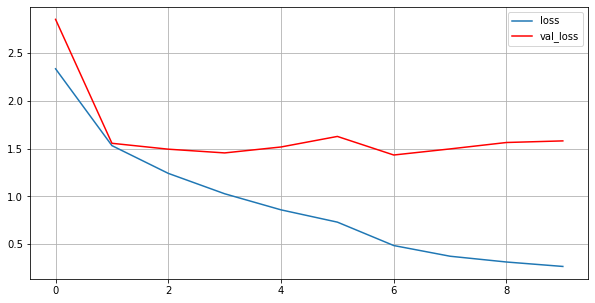

In [33]:
plt.figure(figsize=(10,5))


plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss' , color="red")
plt.grid()
plt.legend()

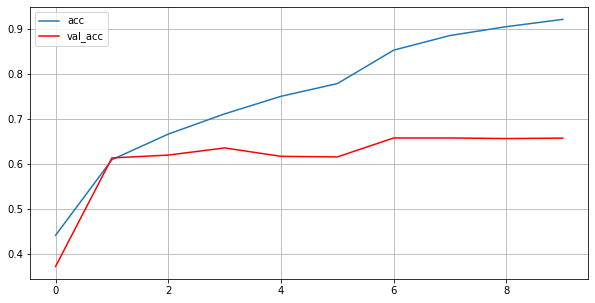

In [34]:
plt.figure(figsize=(10,5))

plt.plot(r.history['accuracy'], label='acc')
plt.plot(r.history['val_accuracy'], label='val_acc',color="red")
plt.grid()
plt.legend()

In [35]:
!mkdir -p saved_model
model.save('saved_model/my_model')

INFO:tensorflow:Assets written to: saved_model/my_model/assets


In [ ]:
import tensorflow as tf
new_model = tf.keras.models.load_model('saved_model/my_model')

# Check its architecture
new_model.summary()